# Aims at calculating the regressed onto NSASMR (All models)

In [1]:
'''
Author: ChenHJ
Date: 2022-10-12 17:40:01
LastEditors: ChenHJ
LastEditTime: 2022-10-12 18:49:25
FilePath: /chenhj/0302code/recalculate_NSASMR.ipynb
Aim: 
Mission: 
'''
# read the packages
# read the packages and datasets
from mailbox import _PartialFile
import numpy as np
import xarray as xr
import os
import re
from cdo import Cdo

import shutil
import sys

sys.path.append("/home/ys17-23/chenhj/self_def/")
import plot as sepl
import cal as ca
import pandas as pd
from importlib import reload

import metpy.calc as mpcalc
import metpy.constants as constants
import geocat.comp
from windspharm.xarray import VectorWind
import skill_metrics as sm
from brokenaxes import brokenaxes

reload(sepl)

# sd.path.append("/home/ys17-23/chenhj/1201code/self_def.py")

cdo = Cdo()

# for plot
import proplot as pplt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter
from cartopy.mpl.ticker import LatitudeFormatter
from cartopy.util import add_cyclic_point
from matplotlib.ticker import MultipleLocator
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import t
from scipy import signal
from eofs.multivariate.standard import MultivariateEof
from eofs.standard import Eof

In [2]:
#   read data from observation data
fpreGPCP = xr.open_dataset(
    "/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/obs/GPCP_r144x72_197901-201412.nc"
)
preGPCP = fpreGPCP["precip"]
preGPCP_JJA = ca.p_time(preGPCP, 6, 8, True)

# preAIR = xr.open_dataarray("/home/ys17-23/Extension/All_India_Rainfall_index/AIR_mmperday.nc")
# preAIR_JJA = ca.p_time(preAIR, 6, 8, True)
# preAIR_JJA = preAIR_JJA.sel(time=(preAIR_JJA.time.dt.year>=1979) & (preAIR_JJA.time.dt.year <=2014))

fhgtERA5 = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/obs/hgt_mon_r144x72_195001-201412.nc")
hgtERA5 = fhgtERA5["z"].sel(time=fhgtERA5["time"].dt.year>=1979)

fuERA5 = xr.open_dataset(
    "/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/obs/uwind_mon_r144x72_195001-201412.nc"
)
uERA5 = fuERA5["u"].sel(time=fuERA5["time"].dt.year>=1979)

fvERA5 = xr.open_dataset(
    "/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/obs/vwind_mon_r144x72_195001-201412.nc"
)
vERA5 = fvERA5["v"].sel(time=fvERA5["time"].dt.year>=1979)

fspERA5 = xr.open_dataset(
    "/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/obs/sp_mon_r144x72_195001-201412.nc"
)
spERA5 = fspERA5["sp"].sel(time=fspERA5["time"].dt.year>=1979)

fqERA5 = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/obs/q_mon_r144x72_195001-201412.nc")
qERA5 = fqERA5["q"].sel(time=fqERA5["time"].dt.year>=1979)

fwERA5 = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/obs/omega_mon_r144x72_195001-201412.nc")
wERA5 = fwERA5["w"].sel(time=fwERA5["time"].dt.year>=1979)

fsstHad = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/obs/HadISST_r144x72_1870-2020.nc")
sstHad = fsstHad["sst"].sel(time=(fsstHad["time"].dt.year>=1979) & (fsstHad["time"].dt.year<=2014))

hgtERA5_ver_JJA = ca.p_time(hgtERA5, 6, 8, True)
hgtERA5_ver_JJA = hgtERA5_ver_JJA-hgtERA5_ver_JJA.mean(dim="lon", skipna=True)
uERA5_ver_JJA = ca.p_time(uERA5, 6, 8, True)
vERA5_ver_JJA = ca.p_time(vERA5, 6, 8, True)
qERA5_ver_JJA = ca.p_time(qERA5, 6, 9, True)
spERA5_JJA = ca.p_time(spERA5, 6, 8, True)
wERA5_JJA = ca.p_time(wERA5, 6, 8, True)
sstHad_JJA = ca.p_time(sstHad, 6, 8, True)

ftERA5 = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/obs/temp_mon_r144x72_195001-201412.nc")
tERA5 = ftERA5["t"].sel(time=ftERA5["time"].dt.year>=1979)
tERA5_ver_JJA = ca.p_time(tERA5, 6, 8, True)


In [3]:
tmp1 = uERA5_ver_JJA.load()
tmp2 = vERA5_ver_JJA.load()
divERA5_ver_JJA = ca.cal_divergence(tmp1.sel(level=[200.0, 850.0]), tmp2.sel(level=[200.0, 850.0]))

In [4]:
# read the data from CMIP6 historical experiment
fprehis = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/CMIP6/historical/tmp_var/JJA/non_detrend/pr_historical_r144x72_195001-201412.nc")
prehis_JJA = fprehis["pr"].sel(time=fprehis["time"].dt.year>=1979)
prehis_JJA.attrs["units"] = "mm/day"
prehis_JJA.attrs["standard_name"] = "precipitation"

fhgthis_ver_JJA = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/CMIP6/historical/tmp_var/JJA/non_detrend/zg_historical_r144x72_195001-201412.nc")
hgthis_ver_JJA = fhgthis_ver_JJA["zg"].sel(time=fhgthis_ver_JJA["time"].dt.year>=1979)
hgthis_ver_JJA = hgthis_ver_JJA - hgthis_ver_JJA.mean(dim="lon", skipna=True)

fuhis_ver_JJA = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/CMIP6/historical/tmp_var/JJA/non_detrend/ua_historical_r144x72_195001-201412.nc")
uhis_ver_JJA = fuhis_ver_JJA["ua"].sel(time=fuhis_ver_JJA["time"].dt.year>=1979)

fvhis_ver_JJA = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/CMIP6/historical/tmp_var/JJA/non_detrend/va_historical_r144x72_195001-201412.nc")
vhis_ver_JJA = fvhis_ver_JJA["va"].sel(time=fvhis_ver_JJA["time"].dt.year>=1979)

fwhis_ver_JJA = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/CMIP6/historical/tmp_var/JJA/non_detrend/wap_historical_r144x72_195001-201412.nc") 
whis_ver_JJA = fwhis_ver_JJA["wap"].sel(time=fwhis_ver_JJA["time"].dt.year>=1979)

fssthis_JJA = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/CMIP6/historical/tmp_var/JJA/non_detrend/tos_historical_r144x72_195001-201412.nc")
ssthis_JJA = fssthis_JJA["tos"].sel(time=fssthis_JJA["time"].dt.year>=1979)

fthis_ver_JJA = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/CMIP6/historical/tmp_var/JJA/non_detrend/ta_historical_r144x72_195001-201412.nc")
this_ver_JJA = fthis_ver_JJA["ta"].sel(time=fthis_ver_JJA["time"].dt.year>=1979)

In [5]:
# read the data from CMIP6 ssp585 experiment and read the last period of ssp585
fpressp585_p3 = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/CMIP6/ssp585/tmp_var/JJA/non_detrend/pr_ssp585_r144x72_201501-209912.nc")
pressp585_p3_JJA = fpressp585_p3["pr"].sel(time=fpressp585_p3.time.dt.year>=2064)
pressp585_p3_JJA.attrs["units"] = "mm/day"
pressp585_p3_JJA.attrs["standard_name"] = "precipitation"

fhgtssp585_p3_ver_JJA = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/CMIP6/ssp585/tmp_var/JJA/non_detrend/zg_ssp585_r144x72_201501-209912.nc")
hgtssp585_p3_ver_JJA = fhgtssp585_p3_ver_JJA["zg"].sel(time=fhgtssp585_p3_ver_JJA.time.dt.year>=2064)
hgtssp585_p3_ver_JJA = hgtssp585_p3_ver_JJA - hgtssp585_p3_ver_JJA.mean(dim="lon", skipna=True)


fussp585_p3_ver_JJA = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/CMIP6/ssp585/tmp_var/JJA/non_detrend/ua_ssp585_r144x72_201501-209912.nc")
ussp585_p3_ver_JJA = fussp585_p3_ver_JJA["ua"].sel(time=fussp585_p3_ver_JJA.time.dt.year>=2064)

fvssp585_p3_ver_JJA = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/CMIP6/ssp585/tmp_var/JJA/non_detrend/va_ssp585_r144x72_201501-209912.nc")
vssp585_p3_ver_JJA = fvssp585_p3_ver_JJA["va"].sel(time=fvssp585_p3_ver_JJA.time.dt.year>=2064)

fwssp585_p3_ver_JJA = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/CMIP6/ssp585/tmp_var/JJA/non_detrend/wap_ssp585_r144x72_201501-209912.nc")
wssp585_p3_ver_JJA = fwssp585_p3_ver_JJA["wap"].sel(time=fwssp585_p3_ver_JJA.time.dt.year>=2064)

fsstssp585_p3_JJA = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/CMIP6/ssp585/tmp_var/JJA/non_detrend/tos_ssp585_r144x72_201501-209912.nc")
sstssp585_p3_JJA = fsstssp585_p3_JJA["tos"].sel(time=fsstssp585_p3_JJA.time.dt.year>=2064)

ftssp585_p3_ver_JJA = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/CMIP6/ssp585/tmp_var/JJA/non_detrend/ta_ssp585_r144x72_201501-209912.nc")
tssp585_p3_ver_JJA = ftssp585_p3_ver_JJA["ta"].sel(time=ftssp585_p3_ver_JJA.time.dt.year>=2064)

In [6]:
tmp1 = uhis_ver_JJA.load()
tmp2 = vhis_ver_JJA.load()
divhis_ver_JJA = ca.cal_divergence(tmp1.sel(level=[200.0, 850.0]), tmp2.sel(level=[200.0, 850.0]))
tmp1 = ussp585_p3_ver_JJA.load()
tmp2 = vssp585_p3_ver_JJA.load()
divssp585_p3_ver_JJA = ca.cal_divergence(tmp1.sel(level=[200.0, 850.0]), tmp2.sel(level=[200.0, 850.0]))

In [7]:
#   deal with the time index for GPCP data
preGPCP_JJA.coords["time"] = prehis_JJA.sel(time=prehis_JJA.time.dt.year>=1979).coords["time"]

models = uhis_ver_JJA.coords["models"]
models_array = models.data

In [8]:
#   calculate the vorticity in ERA5, historical and ssp585
vorERA5_ver_JJA = mpcalc.vorticity(uERA5_ver_JJA.sel(level=200.0), vERA5_ver_JJA.sel(level=200.0))
vorERA5_ver_JJA = vorERA5_ver_JJA.metpy.dequantify()

vorhis_ver_JJA = mpcalc.vorticity(uhis_ver_JJA.sel(level=200.0), vhis_ver_JJA.sel(level=200.0))
vorhis_ver_JJA = vorhis_ver_JJA.metpy.dequantify()

vorssp585_p3_ver_JJA = mpcalc.vorticity(ussp585_p3_ver_JJA.sel(level=200.0), vssp585_p3_ver_JJA.sel(level=200.0))
vorssp585_p3_ver_JJA = vorssp585_p3_ver_JJA.metpy.dequantify()

In [ ]:
# calculate the area-mean precipitation
lat = preGPCP_JJA.coords["lat"]
lon = preGPCP_JJA.coords["lon"]
# north India
nIndia_N = 32.5
# nIndia_N = 30.0
nIndia_S = 25.0
nIndia_W = 70.0
nIndia_E = 85.0
lat_nIndia_range = lat[(lat >= nIndia_S) & (lat <= nIndia_N)]
lon_nIndia_range = lon[(lon >= nIndia_W) & (lon <= nIndia_E)]

preGPCP_nIndia_JJA = ca.cal_lat_weighted_mean(preGPCP_JJA.sel(lat=lat_nIndia_range, lon=lon_nIndia_range)).mean(dim="lon", skipna=True)
prehis_nIndia_JJA = ca.cal_lat_weighted_mean(prehis_JJA.sel(lat=lat_nIndia_range, lon=lon_nIndia_range)).mean(dim="lon", skipna=True)
pressp585_p3_nIndia_JJA = ca.cal_lat_weighted_mean(pressp585_p3_JJA.sel(lat=lat_nIndia_range, lon=lon_nIndia_range)).mean(dim="lon", skipna=True)

# standardize
preGPCP_nIndia_JJA_nor = ca.standardize(preGPCP_nIndia_JJA)
prehis_nIndia_JJA_nor = ca.standardize(prehis_nIndia_JJA)
pressp585_p3_nIndia_JJA_nor = ca.standardize(pressp585_p3_nIndia_JJA)

In [ ]:
#  Northern China
NC_N = 40.0
NC_S = 32.5
NC_W = 105.0
NC_E = 120.0
lat_NC_range = lat[(lat >= NC_S) & (lat <= NC_N)]
lon_NC_range = lon[(lon >= NC_W) & (lon <= NC_E)]
preGPCP_NC_JJA = ca.cal_lat_weighted_mean(preGPCP_JJA.sel(lat=lat_NC_range, lon=lon_NC_range)).mean(dim="lon", skipna=True)
prehis_NC_JJA = ca.cal_lat_weighted_mean(prehis_JJA.sel(lat=lat_NC_range, lon=lon_NC_range)).mean(dim="lon", skipna=True)
pressp585_p3_NC_JJA = ca.cal_lat_weighted_mean(pressp585_p3_JJA.sel(lat=lat_NC_range, lon=lon_NC_range)).mean(dim="lon", skipna=True)

In [ ]:
#   calculate the vorticity over the West Asia in 200hPa
WAhigh_N = 50.0
WAhigh_S = 25.0
WAhigh_W = 50.0
WAhigh_E = 80.0
lat_WAhigh_range = lat[(lat>=WAhigh_S) & (lat<=WAhigh_N)]
lon_WAhigh_range = lon[(lon>=WAhigh_W) & (lon<=WAhigh_E)]
# uERA5_WAhigh_JJA = uERA5_ver_JJA.sel(lat=lat_WAhigh_range, lon=lon_WAhigh_range, level=200.0)
# uhis_WAhigh_JJA = uhis_ver_JJA.sel(lat=lat_WAhigh_range, lon=lon_WAhigh_range, level=200.0)
# ussp585_p3_WAhigh_JJA = ussp585_p3_ver_JJA.sel(lat=lat_WAhigh_range, lon=lon_WAhigh_range, level=200.0)

# vERA5_WAhigh_JJA = vERA5_ver_JJA.sel(lat=lat_WAhigh_range, lon=lon_WAhigh_range, level=200.0)
# vhis_WAhigh_JJA = vhis_ver_JJA.sel(lat=lat_WAhigh_range, lon=lon_WAhigh_range, level=200.0)
# vssp585_p3_WAhigh_JJA = vssp585_p3_ver_JJA.sel(lat=lat_WAhigh_range, lon=lon_WAhigh_range, level=200.0)

# vorERA5_WAhigh_JJA = ca.cal_lat_weighted_mean(mpcalc.vorticity(uERA5_WAhigh_JJA, vERA5_WAhigh_JJA)).mean(dim="lon", skipna=True).metpy.dequantify()
# vorhis_WAhigh_JJA = ca.cal_lat_weighted_mean(mpcalc.vorticity(uhis_WAhigh_JJA, vhis_WAhigh_JJA)).mean(dim="lon", skipna=True).metpy.dequantify()
# vorssp585_p3_WAhigh_JJA = ca.cal_lat_weighted_mean(mpcalc.vorticity(ussp585_p3_WAhigh_JJA, vssp585_p3_WAhigh_JJA)).mean(dim="lon", skipna=True).metpy.dequantify()

In [ ]:
#   calculate the 200hPa vorticity over the East Asia
EAhigh_N = 50.0
EAhigh_S = 27.5
EAhigh_W = 105.0
EAhigh_E = 140.0
lat_EAhigh_range = lat[(lat>=EAhigh_S) & (lat<=EAhigh_N)]
lon_EAhigh_range = lon[(lon>=EAhigh_W) & (lon<=EAhigh_E)]
# uERA5_EAhigh_JJA = uERA5_ver_JJA.sel(lat=lat_EAhigh_range, lon=lon_EAhigh_range, level=200.0)
# uhis_EAhigh_JJA = uhis_ver_JJA.sel(lat=lat_EAhigh_range, lon=lon_EAhigh_range, level=200.0)
# ussp585_p3_EAhigh_JJA = ussp585_p3_ver_JJA.sel(lat=lat_EAhigh_range, lon=lon_EAhigh_range, level=200.0)

# vERA5_EAhigh_JJA = vERA5_ver_JJA.sel(lat=lat_EAhigh_range, lon=lon_EAhigh_range, level=200.0)
# vhis_EAhigh_JJA = vhis_ver_JJA.sel(lat=lat_EAhigh_range, lon=lon_EAhigh_range, level=200.0)
# vssp585_p3_EAhigh_JJA = vssp585_p3_ver_JJA.sel(lat=lat_EAhigh_range, lon=lon_EAhigh_range, level=200.0)

# vorERA5_EAhigh_JJA = ca.cal_lat_weighted_mean(mpcalc.vorticity(uERA5_EAhigh_JJA, vERA5_EAhigh_JJA)).mean(dim="lon", skipna=True).metpy.dequantify()
# vorhis_EAhigh_JJA = ca.cal_lat_weighted_mean(mpcalc.vorticity(uhis_EAhigh_JJA, vhis_EAhigh_JJA)).mean(dim="lon", skipna=True).metpy.dequantify()
# vorssp585_p3_EAhigh_JJA = ca.cal_lat_weighted_mean(mpcalc.vorticity(ussp585_p3_EAhigh_JJA, vssp585_p3_EAhigh_JJA)).mean(dim="lon", skipna=True).metpy.dequantify()

In [ ]:
#   calculate the vorticity over the West Asia in 200hPa
WNPhigh_N = 37.5
WNPhigh_S = 15.0
WNPhigh_W = 110.0
WNPhigh_E = 140.0
lat_WNPhigh_range = lat[(lat>=WNPhigh_S) & (lat<=WNPhigh_N)]
lon_WNPhigh_range = lon[(lon>=WNPhigh_W) & (lon<=WNPhigh_E)]
# uERA5_WNPhigh_JJA = uERA5_ver_JJA.sel(lat=lat_WNPhigh_range, lon=lon_WNPhigh_range, level=850.0)
# uhis_WNPhigh_JJA = uhis_ver_JJA.sel(lat=lat_WNPhigh_range, lon=lon_WNPhigh_range, level=850.0)
# ussp585_p3_WNPhigh_JJA = ussp585_p3_ver_JJA.sel(lat=lat_WNPhigh_range, lon=lon_WNPhigh_range, level=850.0)

# vERA5_WNPhigh_JJA = vERA5_ver_JJA.sel(lat=lat_WNPhigh_range, lon=lon_WNPhigh_range, level=850.0)
# vhis_WNPhigh_JJA = vhis_ver_JJA.sel(lat=lat_WNPhigh_range, lon=lon_WNPhigh_range, level=850.0)
# vssp585_p3_WNPhigh_JJA = vssp585_p3_ver_JJA.sel(lat=lat_WNPhigh_range, lon=lon_WNPhigh_range, level=850.0)

# vorERA5_WNPhigh_JJA = ca.cal_lat_weighted_mean(mpcalc.vorticity(uERA5_WNPhigh_JJA, vERA5_WNPhigh_JJA)).mean(dim="lon", skipna=True).metpy.dequantify()
# vorhis_WNPhigh_JJA = ca.cal_lat_weighted_mean(mpcalc.vorticity(uhis_WNPhigh_JJA, vhis_WNPhigh_JJA)).mean(dim="lon", skipna=True).metpy.dequantify()
# vorssp585_p3_WNPhigh_JJA = ca.cal_lat_weighted_mean(mpcalc.vorticity(ussp585_p3_WNPhigh_JJA, vssp585_p3_WNPhigh_JJA)).mean(dim="lon", skipna=True).metpy.dequantify()

In [6]:
#   calculate the precipitation fields regression onto IndR
(
    pre_GPCP_nIndia_pre_slope,
    pre_GPCP_nIndia_pre_intercept,
    pre_GPCP_nIndia_pre_rvalue,
    pre_GPCP_nIndia_pre_pvalue,
    pre_GPCP_nIndia_pre_hypothesis,
) = ca.dim_linregress(preGPCP_nIndia_JJA_nor, preGPCP_JJA)

(
    pre_his_nIndia_pre_slope,
    pre_his_nIndia_pre_intercept,
    pre_his_nIndia_pre_rvalue,
    pre_his_nIndia_pre_pvalue,
    pre_his_nIndia_pre_hypothesis,
) = ca.dim_linregress(prehis_nIndia_JJA_nor, prehis_JJA)

(
    pre_ssp585_p3_nIndia_pre_slope,
    pre_ssp585_p3_nIndia_pre_intercept,
    pre_ssp585_p3_nIndia_pre_rvalue,
    pre_ssp585_p3_nIndia_pre_pvalue,
    pre_ssp585_p3_nIndia_pre_hypothesis,
) = ca.dim_linregress(pressp585_p3_nIndia_JJA_nor, pressp585_p3_JJA)

NameError: name 'preGPCP_nIndia_JJA_nor' is not defined

In [ ]:
# save the precipitation regression results
pre_GPCP_nIndia_pre_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], pre_GPCP_nIndia_pre_slope.data),
        intercept=(["lat", "lon"], pre_GPCP_nIndia_pre_intercept.data),
        rvalue=(["lat", "lon"], pre_GPCP_nIndia_pre_rvalue.data),
        pvalue=(["lat", "lon"], pre_GPCP_nIndia_pre_pvalue.data),
        hypothesis=(["lat", "lon"], pre_GPCP_nIndia_pre_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="precipitation fields of GPCP regress onto 1979-2014 IndR"),
)

pre_his_nIndia_pre_regress = xr.Dataset(
    data_vars=dict(
        slope=(["models", "lat", "lon"], pre_his_nIndia_pre_slope.data),
        intercept=(["models", "lat", "lon"], pre_his_nIndia_pre_intercept.data),
        rvalue=(["models", "lat", "lon"], pre_his_nIndia_pre_rvalue.data),
        pvalue=(["models", "lat", "lon"], pre_his_nIndia_pre_pvalue.data),
        hypothesis=(["models", "lat", "lon"], pre_his_nIndia_pre_hypothesis.data),
    ),
    coords=dict(
        models=models_array,
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="precipitation fields of historical regress onto 1979-2014 IndR"),
)

pre_ssp585_p3_nIndia_pre_regress = xr.Dataset(
    data_vars=dict(
        slope=(["models", "lat", "lon"], pre_ssp585_p3_nIndia_pre_slope.data),
        intercept=(["models", "lat", "lon"], pre_ssp585_p3_nIndia_pre_intercept.data),
        rvalue=(["models", "lat", "lon"], pre_ssp585_p3_nIndia_pre_rvalue.data),
        pvalue=(["models", "lat", "lon"], pre_ssp585_p3_nIndia_pre_pvalue.data),
        hypothesis=(["models", "lat", "lon"], pre_ssp585_p3_nIndia_pre_hypothesis.data),
    ),
    coords=dict(
        models=models_array,
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="precipitation fields of ssp585 regress onto 2064-2099 IndR"),
)


pre_GPCP_nIndia_pre_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSAMSR_reg_result/non-detrend/pre_GPCP_nIndia_pre_regress.nc")

pre_his_nIndia_pre_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSAMSR_reg_result/non-detrend/pre_his_nIndia_pre_regress.nc")

pre_ssp585_p3_nIndia_pre_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSAMSR_reg_result/non-detrend/pre_ssp585_p3_nIndia_pre_regress.nc")


In [ ]:
#   calculate the MME for historical and ssp585_p3
pre_his_nIndia_pre_slope_ens = pre_his_nIndia_pre_slope.mean(dim="models", skipna=True)

pre_his_nIndia_pre_slope_ens_mask = xr.where((ca.MME_reg_mask(pre_his_nIndia_pre_slope_ens, pre_his_nIndia_pre_slope.std(dim="models", skipna=True), len(pre_his_nIndia_pre_slope.coords["models"]), True) + ca.cal_mmemask(pre_his_nIndia_pre_slope)) >= 2.0, 1.0, 0.0)

# pre_his_nIndia_pre_rvalue_ens = ca.cal_rMME(pre_his_nIndia_pre_rvalue,"models")

# pre_his_nIndia_pre_rvalue_ens_mask = xr.where((ca.MME_reg_mask(pre_his_nIndia_pre_rvalue_ens, pre_his_nIndia_pre_rvalue.std(dim="models", skipna=True), len(pre_his_nIndia_pre_rvalue.coords["models"]), True) + ca.cal_mmemask(pre_his_nIndia_pre_slope)) >= 2.0, 1.0, 0.0)

pre_ssp585_p3_nIndia_pre_slope_ens = pre_ssp585_p3_nIndia_pre_slope.mean(dim="models", skipna=True)

pre_ssp585_p3_nIndia_pre_slope_ens_mask = xr.where((ca.MME_reg_mask(pre_ssp585_p3_nIndia_pre_slope_ens, pre_ssp585_p3_nIndia_pre_slope.std(dim="models", skipna=True), len(pre_ssp585_p3_nIndia_pre_slope.coords["models"]), True) + ca.cal_mmemask(pre_ssp585_p3_nIndia_pre_slope)) >= 2.0, 1.0, 0.0)

# pre_ssp585_p3_nIndia_pre_rvalue_ens = ca.cal_rMME(pre_ssp585_p3_nIndia_pre_rvalue,"models")

# pre_ssp585_p3_nIndia_pre_rvalue_ens_mask = xr.where((ca.MME_reg_mask(pre_ssp585_p3_nIndia_pre_rvalue_ens, pre_ssp585_p3_nIndia_pre_rvalue.std(dim="models", skipna=True), len(pre_ssp585_p3_nIndia_pre_rvalue.coords["models"]), True) + ca.cal_mmemask(pre_ssp585_p3_nIndia_pre_slope)) >= 2.0, 1.0, 0.0)

In [ ]:
# recalculate the regression data
preGPCP_nIndia_JJA_nor.coords["time"] = hgtERA5_ver_JJA.time
(
    nIndR_ERA5_hgt_slope,
    nIndR_ERA5_hgt_intercept,
    nIndR_ERA5_hgt_rvalue,
    nIndR_ERA5_hgt_pvalue,
    nIndR_ERA5_hgt_hypothesis,
) = ca.dim_linregress(preGPCP_nIndia_JJA_nor, hgtERA5_ver_JJA.sel(level=[200.0, 500.0, 850.0]))

(
    nIndR_ERA5_u_slope,
    nIndR_ERA5_u_intercept,
    nIndR_ERA5_u_rvalue,
    nIndR_ERA5_u_pvalue,
    nIndR_ERA5_u_hypothesis,
) = ca.dim_linregress(preGPCP_nIndia_JJA_nor, uERA5_ver_JJA.sel(level=[200.0, 500.0, 850.0]))

(
    nIndR_ERA5_v_slope,
    nIndR_ERA5_v_intercept,
    nIndR_ERA5_v_rvalue,
    nIndR_ERA5_v_pvalue,
    nIndR_ERA5_v_hypothesis,
) = ca.dim_linregress(preGPCP_nIndia_JJA_nor, vERA5_ver_JJA.sel(level=[200.0, 500.0, 850.0]))

(
    nIndR_his_hgt_slope,
    nIndR_his_hgt_intercept,
    nIndR_his_hgt_rvalue,
    nIndR_his_hgt_pvalue,
    nIndR_his_hgt_hypothesis,
) = ca.dim_linregress(prehis_nIndia_JJA_nor, hgthis_ver_JJA.sel(level=[200.0, 500.0, 850.0]))

(
    nIndR_his_u_slope,
    nIndR_his_u_intercept,
    nIndR_his_u_rvalue,
    nIndR_his_u_pvalue,
    nIndR_his_u_hypothesis,
) = ca.dim_linregress(prehis_nIndia_JJA_nor, uhis_ver_JJA.sel(level=[200.0, 500.0, 850.0]))

(
    nIndR_his_v_slope,
    nIndR_his_v_intercept,
    nIndR_his_v_rvalue,
    nIndR_his_v_pvalue,
    nIndR_his_v_hypothesis,
) = ca.dim_linregress(prehis_nIndia_JJA_nor, vhis_ver_JJA.sel(level=[200.0, 500.0, 850.0]))

(
    nIndR_ssp585_p3_hgt_slope,
    nIndR_ssp585_p3_hgt_intercept,
    nIndR_ssp585_p3_hgt_rvalue,
    nIndR_ssp585_p3_hgt_pvalue,
    nIndR_ssp585_p3_hgt_hypothesis,
) = ca.dim_linregress(pressp585_p3_nIndia_JJA_nor, hgtssp585_p3_ver_JJA.sel(level=[200.0, 500.0, 850.0]))

(
    nIndR_ssp585_p3_u_slope,
    nIndR_ssp585_p3_u_intercept,
    nIndR_ssp585_p3_u_rvalue,
    nIndR_ssp585_p3_u_pvalue,
    nIndR_ssp585_p3_u_hypothesis,
) = ca.dim_linregress(pressp585_p3_nIndia_JJA_nor, ussp585_p3_ver_JJA.sel(level=[200.0, 500.0, 850.0]))

(
    nIndR_ssp585_p3_v_slope,
    nIndR_ssp585_p3_v_intercept,
    nIndR_ssp585_p3_v_rvalue,
    nIndR_ssp585_p3_v_pvalue,
    nIndR_ssp585_p3_v_hypothesis,
) = ca.dim_linregress(pressp585_p3_nIndia_JJA_nor, vssp585_p3_ver_JJA.sel(level=[200.0, 500.0, 850.0]))



In [ ]:
# save the variable into *.nc files
level = nIndR_his_hgt_slope.coords["level"]
lat = nIndR_his_hgt_slope.coords["lat"]
lon = nIndR_his_hgt_slope.coords["lon"]

nIndR_ERA5_hgt_regress = xr.Dataset(
    data_vars=dict(
        slope=(["level", "lat", "lon"], nIndR_ERA5_hgt_slope.data),
        intercept=(["level", "lat", "lon"], nIndR_ERA5_hgt_intercept.data),
        rvalue=(["level", "lat", "lon"], nIndR_ERA5_hgt_rvalue.data),
        pvalue=(["level", "lat", "lon"], nIndR_ERA5_hgt_pvalue.data),
        hypothesis=(["level", "lat", "lon"], nIndR_ERA5_hgt_hypothesis.data),
    ),
    coords=dict(
        level=level.data,
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="hgt fields of ERA5 regress onto 1979-2014 "),
)

nIndR_ERA5_u_regress = xr.Dataset(
    data_vars=dict(
        slope=(["level", "lat", "lon"], nIndR_ERA5_u_slope.data),
        intercept=(["level", "lat", "lon"], nIndR_ERA5_u_intercept.data),
        rvalue=(["level", "lat", "lon"], nIndR_ERA5_u_rvalue.data),
        pvalue=(["level", "lat", "lon"], nIndR_ERA5_u_pvalue.data),
        hypothesis=(["level", "lat", "lon"], nIndR_ERA5_u_hypothesis.data),
    ),
    coords=dict(
        level=level.data,
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="u fields of ERA5 regress onto 1979-2014 "),
)

nIndR_ERA5_v_regress = xr.Dataset(
    data_vars=dict(
        slope=(["level", "lat", "lon"], nIndR_ERA5_v_slope.data),
        intercept=(["level", "lat", "lon"], nIndR_ERA5_v_intercept.data),
        rvalue=(["level", "lat", "lon"], nIndR_ERA5_v_rvalue.data),
        pvalue=(["level", "lat", "lon"], nIndR_ERA5_v_pvalue.data),
        hypothesis=(["level", "lat", "lon"], nIndR_ERA5_v_hypothesis.data),
    ),
    coords=dict(
        level=level.data,
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="v fields of ERA5 regress onto 1979-2014 "),
)

nIndR_his_hgt_regress = xr.Dataset(
    data_vars=dict(
        slope=(["models", "level", "lat", "lon"], nIndR_his_hgt_slope.data),
        intercept=(["models", "level", "lat", "lon"], nIndR_his_hgt_intercept.data),
        rvalue=(["models", "level", "lat", "lon"], nIndR_his_hgt_rvalue.data),
        pvalue=(["models", "level", "lat", "lon"], nIndR_his_hgt_pvalue.data),
        hypothesis=(["models", "level", "lat", "lon"], nIndR_his_hgt_hypothesis.data),
    ),
    coords=dict(
        models=models.data,
        level=level.data,
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="hgt fields of historical regress onto 1979-2014 nIndR"),
)

nIndR_his_u_regress = xr.Dataset(
    data_vars=dict(
        slope=(["models", "level", "lat", "lon"], nIndR_his_u_slope.data),
        intercept=(["models", "level", "lat", "lon"], nIndR_his_u_intercept.data),
        rvalue=(["models", "level", "lat", "lon"], nIndR_his_u_rvalue.data),
        pvalue=(["models", "level", "lat", "lon"], nIndR_his_u_pvalue.data),
        hypothesis=(["models", "level", "lat", "lon"], nIndR_his_u_hypothesis.data),
    ),
    coords=dict(
        models=models.data,
        level=level.data,
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="u fields of historical regress onto 1979-2014 nIndR"),
)

nIndR_his_v_regress = xr.Dataset(
    data_vars=dict(
        slope=(["models", "level", "lat", "lon"], nIndR_his_v_slope.data),
        intercept=(["models", "level", "lat", "lon"], nIndR_his_v_intercept.data),
        rvalue=(["models", "level", "lat", "lon"], nIndR_his_v_rvalue.data),
        pvalue=(["models", "level", "lat", "lon"], nIndR_his_v_pvalue.data),
        hypothesis=(["models", "level", "lat", "lon"], nIndR_his_v_hypothesis.data),
    ),
    coords=dict(
        models=models.data,
        level=level.data,
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="v fields of historical regress onto 1979-2014 nIndR"),
)

nIndR_ssp585_p3_hgt_regress = xr.Dataset(
    data_vars=dict(
        slope=(["models", "level", "lat", "lon"], nIndR_ssp585_p3_hgt_slope.data),
        intercept=(["models", "level", "lat", "lon"], nIndR_ssp585_p3_hgt_intercept.data),
        rvalue=(["models", "level", "lat", "lon"], nIndR_ssp585_p3_hgt_rvalue.data),
        pvalue=(["models", "level", "lat", "lon"], nIndR_ssp585_p3_hgt_pvalue.data),
        hypothesis=(["models", "level", "lat", "lon"], nIndR_ssp585_p3_hgt_hypothesis.data),
    ),
    coords=dict(
        models=models.data,
        level=level.data,
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="hgt fields of ssp585_p3 regress onto 2064-2099 nIndR"),
)

nIndR_ssp585_p3_u_regress = xr.Dataset(
    data_vars=dict(
        slope=(["models", "level", "lat", "lon"], nIndR_ssp585_p3_u_slope.data),
        intercept=(["models", "level", "lat", "lon"], nIndR_ssp585_p3_u_intercept.data),
        rvalue=(["models", "level", "lat", "lon"], nIndR_ssp585_p3_u_rvalue.data),
        pvalue=(["models", "level", "lat", "lon"], nIndR_ssp585_p3_u_pvalue.data),
        hypothesis=(["models", "level", "lat", "lon"], nIndR_ssp585_p3_u_hypothesis.data),
    ),
    coords=dict(
        models=models.data,
        level=level.data,
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="u fields of ssp585_p3 regress onto 2064-2099 nIndR"),
)

nIndR_ssp585_p3_v_regress = xr.Dataset(
    data_vars=dict(
        slope=(["models", "level", "lat", "lon"], nIndR_ssp585_p3_v_slope.data),
        intercept=(["models", "level", "lat", "lon"], nIndR_ssp585_p3_v_intercept.data),
        rvalue=(["models", "level", "lat", "lon"], nIndR_ssp585_p3_v_rvalue.data),
        pvalue=(["models", "level", "lat", "lon"], nIndR_ssp585_p3_v_pvalue.data),
        hypothesis=(["models", "level", "lat", "lon"], nIndR_ssp585_p3_v_hypothesis.data),
    ),
    coords=dict(
        models=models.data,
        level=level.data,
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="v fields of ssp585_p3 regress onto 2064-2099 nIndR"),
)

nIndR_ERA5_hgt_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSAMSR_reg_result/non-detrend/nIndR_ERA5_hgt_regress_std.nc")
nIndR_ERA5_u_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSAMSR_reg_result/non-detrend/nIndR_ERA5_u_regress_std.nc")
nIndR_ERA5_v_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSAMSR_reg_result/non-detrend/nIndR_ERA5_v_regress_std.nc")

nIndR_his_hgt_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSAMSR_reg_result/non-detrend/nIndR_his_hgt_regress_std.nc")
nIndR_his_u_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSAMSR_reg_result/non-detrend/nIndR_his_u_regress_std.nc")
nIndR_his_v_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSAMSR_reg_result/non-detrend/nIndR_his_v_regress_std.nc")

nIndR_ssp585_p3_hgt_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSAMSR_reg_result/non-detrend/nIndR_ssp585_p3_hgt_regress_std.nc")
nIndR_ssp585_p3_u_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSAMSR_reg_result/non-detrend/nIndR_ssp585_p3_u_regress_std.nc")
nIndR_ssp585_p3_v_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSAMSR_reg_result/non-detrend/nIndR_ssp585_p3_v_regress_std.nc")

In [ ]:
# calculate the omega regress onto the precipitation
preGPCP_nIndia_JJA_nor.coords["time"] = wERA5_JJA.time
(
    nIndR_ERA5_w_slope,
    nIndR_ERA5_w_intercept,
    nIndR_ERA5_w_rvalue,
    nIndR_ERA5_w_pvalue,
    nIndR_ERA5_w_hypothesis,
) = ca.dim_linregress(preGPCP_nIndia_JJA_nor, wERA5_JJA.sel(level=500.0))

(
    nIndR_his_w_slope,
    nIndR_his_w_intercept,
    nIndR_his_w_rvalue,
    nIndR_his_w_pvalue,
    nIndR_his_w_hypothesis,
) = ca.dim_linregress(prehis_nIndia_JJA_nor, whis_ver_JJA.sel(level=500.0))

(
    nIndR_ssp585_p3_w_slope,
    nIndR_ssp585_p3_w_intercept,
    nIndR_ssp585_p3_w_rvalue,
    nIndR_ssp585_p3_w_pvalue,
    nIndR_ssp585_p3_w_hypothesis,
) = ca.dim_linregress(pressp585_p3_nIndia_JJA_nor, wssp585_p3_ver_JJA.sel(level=500.0))

# calculate the divergence regress onto the precipitation
(
    nIndR_ERA5_div_slope,
    nIndR_ERA5_div_intercept,
    nIndR_ERA5_div_rvalue,
    nIndR_ERA5_div_pvalue,
    nIndR_ERA5_div_hypothesis,
) = ca.dim_linregress(preGPCP_nIndia_JJA_nor, divERA5_ver_JJA)

(
    nIndR_his_div_slope,
    nIndR_his_div_intercept,
    nIndR_his_div_rvalue,
    nIndR_his_div_pvalue,
    nIndR_his_div_hypothesis,
) = ca.dim_linregress(prehis_nIndia_JJA_nor, divhis_ver_JJA)

(
    nIndR_ssp585_p3_div_slope,
    nIndR_ssp585_p3_div_intercept,
    nIndR_ssp585_p3_div_rvalue,
    nIndR_ssp585_p3_div_pvalue,
    nIndR_ssp585_p3_div_hypothesis,
) = ca.dim_linregress(pressp585_p3_nIndia_JJA_nor, divssp585_p3_ver_JJA)


In [ ]:
#   calculate the windcheck and ensmean
nIndR_ERA5_wind_mask = ca.wind_check(
    xr.where(nIndR_ERA5_u_pvalue <= 0.05, 1.0, 0.0),
    xr.where(nIndR_ERA5_v_pvalue <= 0.05, 1.0, 0.0),
    xr.where(nIndR_ERA5_u_pvalue <= 0.05, 1.0, 0.0),
    xr.where(nIndR_ERA5_v_pvalue <= 0.05, 1.0, 0.0),
)

nIndR_his_wind_mask = ca.wind_check(
    xr.where(nIndR_his_u_pvalue <= 0.05, 1.0, 0.0),
    xr.where(nIndR_his_v_pvalue <= 0.05, 1.0, 0.0),
    xr.where(nIndR_his_u_pvalue <= 0.05, 1.0, 0.0),
    xr.where(nIndR_his_v_pvalue <= 0.05, 1.0, 0.0),
)

nIndR_ssp585_p3_wind_mask = ca.wind_check(
    xr.where(nIndR_ssp585_p3_u_pvalue <= 0.05, 1.0, 0.0),
    xr.where(nIndR_ssp585_p3_v_pvalue <= 0.05, 1.0, 0.0),
    xr.where(nIndR_ssp585_p3_u_pvalue <= 0.05, 1.0, 0.0),
    xr.where(nIndR_ssp585_p3_v_pvalue <= 0.05, 1.0, 0.0),
)

nIndR_his_hgt_slope_ens = nIndR_his_hgt_slope.mean(dim="models", skipna=True)
nIndR_his_hgt_slope_ens_mask = xr.where((ca.MME_reg_mask(nIndR_his_hgt_slope_ens, nIndR_his_hgt_slope.std(dim="models", skipna=True), len(models), True) + ca.cal_mmemask(nIndR_his_hgt_slope)) >= 2.0, 1.0, 0.0)

nIndR_ssp585_p3_hgt_slope_ens = nIndR_ssp585_p3_hgt_slope.mean(dim="models", skipna=True)
nIndR_ssp585_p3_hgt_slope_ens_mask = xr.where((ca.MME_reg_mask(nIndR_ssp585_p3_hgt_slope_ens, nIndR_ssp585_p3_hgt_slope.std(dim="models", skipna=True), len(models), True) + ca.cal_mmemask(nIndR_ssp585_p3_hgt_slope)) >= 2.0, 1.0, 0.0)

nIndR_his_u_slope_ens = nIndR_his_u_slope.mean(dim="models", skipna=True)
nIndR_his_u_slope_ens_mask = xr.where((ca.MME_reg_mask(nIndR_his_u_slope_ens, nIndR_his_u_slope.std(dim="models", skipna=True), len(models), True) + ca.cal_mmemask(nIndR_his_u_slope)) >= 2.0, 1.0, 0.0)

nIndR_ssp585_p3_u_slope_ens = nIndR_ssp585_p3_u_slope.mean(dim="models", skipna=True) 
nIndR_ssp585_p3_u_slope_ens_mask = xr.where((ca.MME_reg_mask(nIndR_ssp585_p3_u_slope_ens, nIndR_ssp585_p3_u_slope.std(dim="models", skipna=True), len(models), True) + ca.cal_mmemask(nIndR_ssp585_p3_u_slope)) >= 2.0, 1.0, 0.0)

nIndR_his_v_slope_ens = nIndR_his_v_slope.mean(dim="models", skipna=True)
nIndR_his_v_slope_ens_mask = xr.where((ca.MME_reg_mask(nIndR_his_v_slope_ens, nIndR_his_v_slope.std(dim="models", skipna=True), len(models), True) + ca.cal_mmemask(nIndR_his_v_slope)) >= 2.0, 1.0, 0.0)

nIndR_ssp585_p3_v_slope_ens = nIndR_ssp585_p3_v_slope.mean(dim="models", skipna=True)
nIndR_ssp585_p3_v_slope_ens_mask = xr.where((ca.MME_reg_mask(nIndR_ssp585_p3_v_slope_ens, nIndR_ssp585_p3_v_slope.std(dim="models", skipna=True), len(models), True) + ca.cal_mmemask(nIndR_ssp585_p3_v_slope)) >= 2.0, 1.0, 0.0)

nIndR_his_hgt_rvalue_ens = ca.cal_rMME(nIndR_his_hgt_rvalue, "models")
nIndR_his_hgt_rvalue_ens_mask = xr.where((ca.MME_reg_mask(nIndR_his_hgt_rvalue_ens, nIndR_his_hgt_rvalue.std(dim="models", skipna=True), len(models), True) + ca.cal_mmemask(nIndR_his_hgt_slope)) >= 2.0, 1.0, 0.0)

nIndR_ssp585_p3_hgt_rvalue_ens = ca.cal_rMME(nIndR_ssp585_p3_hgt_rvalue, "models")
nIndR_ssp585_p3_hgt_rvalue_ens_mask = xr.where((ca.MME_reg_mask(nIndR_ssp585_p3_hgt_rvalue_ens, nIndR_ssp585_p3_hgt_rvalue.std(dim="models", skipna=True), len(models), True) + ca.cal_mmemask(nIndR_ssp585_p3_hgt_slope)) >= 2.0, 1.0, 0.0)

nIndR_his_u_rvalue_ens = ca.cal_rMME(nIndR_his_u_rvalue, "models")
nIndR_his_u_rvalue_ens_mask = xr.where((ca.MME_reg_mask(nIndR_his_u_rvalue_ens, nIndR_his_u_rvalue.std(dim="models", skipna=True), len(models), True) + ca.cal_mmemask(nIndR_his_u_slope)) >= 2.0, 1.0, 0.0)

nIndR_ssp585_p3_u_rvalue_ens = ca.cal_rMME(nIndR_ssp585_p3_u_rvalue, "models")
nIndR_ssp585_p3_u_rvalue_ens_mask = xr.where((ca.MME_reg_mask(nIndR_ssp585_p3_u_rvalue_ens, nIndR_ssp585_p3_u_rvalue.std(dim="models", skipna=True), len(models), True) + ca.cal_mmemask(nIndR_ssp585_p3_u_slope)) >= 2.0, 1.0, 0.0)

nIndR_his_v_rvalue_ens = ca.cal_rMME(nIndR_his_v_rvalue, "models")
nIndR_his_v_rvalue_ens_mask = xr.where((ca.MME_reg_mask(nIndR_his_v_rvalue_ens, nIndR_his_v_rvalue.std(dim="models", skipna=True), len(models), True) + ca.cal_mmemask(nIndR_his_v_slope)) >= 2.0, 1.0, 0.0)

nIndR_ssp585_p3_v_rvalue_ens = ca.cal_rMME(nIndR_ssp585_p3_v_rvalue, "models")
nIndR_ssp585_p3_v_rvalue_ens_mask = xr.where((ca.MME_reg_mask(nIndR_ssp585_p3_v_rvalue_ens, nIndR_ssp585_p3_v_rvalue.std(dim="models", skipna=True), len(models), True) + ca.cal_mmemask(nIndR_ssp585_p3_v_slope)) >= 2.0, 1.0, 0.0)

nIndR_his_wind_ens_mask = ca.wind_check(
    xr.where(nIndR_his_u_slope_ens_mask > 0.0, 1.0, 0.0),
    xr.where(nIndR_his_v_slope_ens_mask > 0.0, 1.0, 0.0),
    xr.where(nIndR_his_u_slope_ens_mask > 0.0, 1.0, 0.0),
    xr.where(nIndR_his_v_slope_ens_mask > 0.0, 1.0, 0.0),
)
nIndR_ssp585_p3_wind_ens_mask = ca.wind_check(
    xr.where(nIndR_ssp585_p3_u_slope_ens_mask > 0.0, 1.0, 0.0),
    xr.where(nIndR_ssp585_p3_v_slope_ens_mask > 0.0, 1.0, 0.0),
    xr.where(nIndR_ssp585_p3_u_slope_ens_mask > 0.0, 1.0, 0.0),
    xr.where(nIndR_ssp585_p3_v_slope_ens_mask > 0.0, 1.0, 0.0),
)

In [ ]:
#   calculate the ranking of different models but use the  data as observation
lat = prehis_JJA.coords["lat"]
lon = prehis_JJA.coords["lon"]

lon_ranking1_W = 50
lon_ranking1_E = 137.5
lat_ranking1_N = 47.5
lat_ranking1_S = 15.0

lon_ranking2_W = 110
lon_ranking2_E = 137.5
lat_ranking2_N = 37.5
lat_ranking2_S = 15.0
#   for 200hPa
lat_ranking_range1 = lat[(lat>=lat_ranking1_S) & (lat<=lat_ranking1_N)]
lon_ranking_range1 = lon[(lon>=lon_ranking1_W) & (lon<=lon_ranking1_E)]

#   for 850hPa
lat_ranking_range2 = lat[(lat>=lat_ranking2_S) & (lat<=lat_ranking2_N)]
lon_ranking_range2 = lon[(lon>=lon_ranking2_W) & (lon<=lon_ranking2_E)]

nIndR_ranking_list = []
nIndR_200hgt_pcc = []

nIndR_850hgt_pcc = []

nIndR_200hgt_RMSE = []
nIndR_200hgt_std = []

nIndR_850hgt_RMSE = []
nIndR_850hgt_std = []


for num_mod, mod in enumerate(models):
    
    hgt200_pcc = ca.cal_pcc(nIndR_ERA5_hgt_slope.sel(lat=lat_ranking_range1, lon=lon_ranking_range1, level=200.0), nIndR_his_hgt_slope.sel(models=mod, lat=lat_ranking_range1, lon=lon_ranking_range1, level=200.0))
    
    hgt850_pcc = ca.cal_pcc(nIndR_ERA5_hgt_slope.sel(lat=lat_ranking_range2, lon=lon_ranking_range2, level=850.0), nIndR_his_hgt_slope.sel(models=mod, lat=lat_ranking_range2, lon=lon_ranking_range2, level=850.0))
    
    # nIndR_ranking_list.append({"models": mod.data, "pcc": hgt_pcc+u_pcc+v_pcc})
    nIndR_ranking_list.append({"models":mod.data, "pcc":hgt200_pcc + hgt850_pcc})
    
    nIndR_200hgt_pcc.append(hgt200_pcc)
    nIndR_850hgt_pcc.append(hgt850_pcc)
    
    nIndR_200hgt_RMSE.append(np.sqrt(np.power((nIndR_his_hgt_slope.sel(models=mod,lat=lat_ranking_range1,lon=lon_ranking_range1, level=200.0)-nIndR_ERA5_hgt_slope.sel(lat=lat_ranking_range1, lon=lon_ranking_range1, level=200.0)),2).mean(dim=["lat","lon"],skipna=True).data))
    
    nIndR_850hgt_RMSE.append(np.sqrt(np.power((nIndR_his_hgt_slope.sel(models=mod,lat=lat_ranking_range2,lon=lon_ranking_range2, level=850.0)-nIndR_ERA5_hgt_slope.sel(lat=lat_ranking_range2, lon=lon_ranking_range2, level=850.0)),2).mean(dim=["lat","lon"],skipna=True).data))
    
    nIndR_200hgt_std.append(float((nIndR_his_hgt_slope.sel(models=mod,lat=lat_ranking_range1,lon=lon_ranking_range1, level=200.0).std(dim=["lat","lon"],skipna=True)/nIndR_ERA5_hgt_slope.sel(lat=lat_ranking_range1, lon=lon_ranking_range1, level=200.0).std(dim=["lat","lon"],skipna=True)).data))
    nIndR_850hgt_std.append(float((nIndR_his_hgt_slope.sel(models=mod,lat=lat_ranking_range2,lon=lon_ranking_range2, level=850.0).std(dim=["lat","lon"],skipna=True)/nIndR_ERA5_hgt_slope.sel(lat=lat_ranking_range2, lon=lon_ranking_range2, level=850.0).std(dim=["lat","lon"],skipna=True)).data))


#   for MME
nIndR_200hgt_pcc.append(ca.cal_pcc(nIndR_ERA5_hgt_slope.sel(lat=lat_ranking_range1, lon=lon_ranking_range1, level=200.0), nIndR_his_hgt_slope_ens.sel(lat=lat_ranking_range1, lon=lon_ranking_range1, level=200.0)))
nIndR_850hgt_pcc.append(ca.cal_pcc(nIndR_ERA5_hgt_slope.sel(lat=lat_ranking_range2, lon=lon_ranking_range2, level=850.0), nIndR_his_hgt_slope_ens.sel(lat=lat_ranking_range2, lon=lon_ranking_range2, level=850.0)))


nIndR_200hgt_RMSE.append(np.sqrt(np.power((nIndR_his_hgt_slope_ens.sel(lat=lat_ranking_range1,lon=lon_ranking_range1, level=200.0)-nIndR_ERA5_hgt_slope.sel(lat=lat_ranking_range1, lon=lon_ranking_range1, level=200.0)),2).mean(dim=["lat","lon"],skipna=True).data))
nIndR_850hgt_RMSE.append(np.sqrt(np.power((nIndR_his_hgt_slope_ens.sel(lat=lat_ranking_range2,lon=lon_ranking_range2, level=850.0)-nIndR_ERA5_hgt_slope.sel(lat=lat_ranking_range2, lon=lon_ranking_range2, level=850.0)),2).mean(dim=["lat","lon"],skipna=True).data))



nIndR_200hgt_std.append(float((nIndR_his_hgt_slope_ens.sel(lat=lat_ranking_range1,lon=lon_ranking_range1, level=200.0).std(dim=["lat","lon"],skipna=True)/nIndR_ERA5_hgt_slope.sel(lat=lat_ranking_range1, lon=lon_ranking_range1, level=200.0).std(dim=["lat","lon"],skipna=True)).data))
nIndR_850hgt_std.append(float((nIndR_his_hgt_slope_ens.sel(lat=lat_ranking_range2,lon=lon_ranking_range2, level=850.0).std(dim=["lat","lon"],skipna=True)/nIndR_ERA5_hgt_slope.sel(lat=lat_ranking_range2, lon=lon_ranking_range2, level=850.0).std(dim=["lat","lon"],skipna=True)).data))


#   pick up the good models and calculate the gMME for hgt, u, v, precip
#   these gmodels are different from the ranking list calculated by the GPCP data
gmodels = ["CAMS-CSM1-0", "CESM2", "CESM2-WACCM", "CMCC-ESM2", "HadGEM3-GC31-LL", "INM-CM4-8", "MRI-ESM2-0", "UKESM1-0-LL"]
# gmodels = ["CESM2-WACCM", "CMCC-ESM2", "MRI-ESM2-0", "UKESM1-0-LL"]
nIndR_his_w_slope_gens = nIndR_his_w_slope.sel(models=gmodels).mean(dim="models", skipna=True)
nIndR_his_w_slope_gens_mask = xr.where((ca.MME_reg_mask(nIndR_his_w_slope_gens, nIndR_his_w_slope.sel(models=gmodels).std(dim="models", skipna=True), len(gmodels), True) + ca.cal_mmemask(nIndR_his_w_slope.sel(models=gmodels))) >= 2.0, 1.0, 0.0)

nIndR_his_div_slope_gens = nIndR_his_div_slope.sel(models=gmodels).mean(dim="models", skipna=True)
nIndR_his_div_slope_gens_mask = xr.where((ca.MME_reg_mask(nIndR_his_div_slope_gens, nIndR_his_div_slope.sel(models=gmodels).std(dim="models", skipna=True), len(gmodels), True) + ca.cal_mmemask(nIndR_his_div_slope.sel(models=gmodels))) >= 2.0, 1.0, 0.0)

pre_his_nIndia_pre_slope_gens = pre_his_nIndia_pre_slope.sel(models=gmodels).mean(dim="models", skipna=True)
pre_ssp585_p3_nIndia_pre_slope_gens = pre_ssp585_p3_nIndia_pre_slope.sel(models=gmodels).mean(dim="models", skipna=True)

pre_his_nIndia_pre_slope_gens_mask = xr.where((ca.MME_reg_mask(pre_his_nIndia_pre_slope_gens, pre_his_nIndia_pre_slope.sel(models=gmodels).std(dim="models", skipna=True), len(gmodels), True) + ca.cal_mmemask(pre_his_nIndia_pre_slope.sel(models=gmodels))) >= 2.0, 1.0, 0.0)
pre_ssp585_p3_nIndia_pre_slope_gens_mask = xr.where((ca.MME_reg_mask(pre_ssp585_p3_nIndia_pre_slope_gens, pre_ssp585_p3_nIndia_pre_slope.sel(models=gmodels).std(dim="models", skipna=True), len(gmodels), True) + ca.cal_mmemask(pre_ssp585_p3_nIndia_pre_slope.sel(models=gmodels))) >= 2.0, 1.0, 0.0)

nIndR_ssp585_p3_w_slope_gens = nIndR_ssp585_p3_w_slope.sel(models=gmodels).mean(dim="models", skipna=True)
nIndR_ssp585_p3_w_slope_gens_mask = xr.where((ca.MME_reg_mask(nIndR_ssp585_p3_w_slope_gens, nIndR_ssp585_p3_w_slope.sel(models=gmodels).std(dim="models", skipna=True), len(gmodels), True) + ca.cal_mmemask(nIndR_ssp585_p3_w_slope.sel(models=gmodels))) >= 2.0, 1.0, 0.0)
nIndR_ssp585_p3_div_slope_gens = nIndR_ssp585_p3_div_slope.sel(models=gmodels).mean(dim="models", skipna=True)
nIndR_ssp585_p3_div_slope_gens_mask = xr.where((ca.MME_reg_mask(nIndR_ssp585_p3_div_slope_gens, nIndR_ssp585_p3_div_slope.sel(models=gmodels).std(dim="models", skipna=True), len(gmodels), True) + ca.cal_mmemask(nIndR_ssp585_p3_div_slope.sel(models=gmodels))) >= 2.0, 1.0, 0.0)

nIndR_his_hgt_slope_gens = nIndR_his_hgt_slope.sel(models=gmodels).mean(dim="models", skipna=True)
nIndR_his_u_slope_gens = nIndR_his_u_slope.sel(models=gmodels).mean(dim="models", skipna=True)
nIndR_his_v_slope_gens = nIndR_his_v_slope.sel(models=gmodels).mean(dim="models", skipna=True)

nIndR_ssp585_p3_hgt_slope_gens = nIndR_ssp585_p3_hgt_slope.sel(models=gmodels).mean(dim="models", skipna=True)
nIndR_ssp585_p3_u_slope_gens = nIndR_ssp585_p3_u_slope.sel(models=gmodels).mean(dim="models", skipna=True)
nIndR_ssp585_p3_v_slope_gens = nIndR_ssp585_p3_v_slope.sel(models=gmodels).mean(dim="models", skipna=True)

# nIndR_his_sst_slope_gens = nIndR_his_sst_slope.sel(models=gmodels).mean(dim="models", skipna=True)

# nIndR_ssp585_p3_sst_slope_gens = nIndR_ssp585_p3_sst_slope.sel(models=gmodels).mean(dim="models", skipna=True)


pre_his_nIndia_pre_rvalue_gens = ca.cal_rMME(pre_his_nIndia_pre_rvalue.sel(models=gmodels), "models")
pre_ssp585_p3_nIndia_pre_rvalue_gens = ca.cal_rMME(pre_ssp585_p3_nIndia_pre_rvalue.sel(models=gmodels), "models")

nIndR_his_hgt_rvalue_gens = ca.cal_rMME(nIndR_his_hgt_rvalue.sel(models=gmodels), "models")
nIndR_his_u_rvalue_gens = ca.cal_rMME(nIndR_his_u_rvalue.sel(models=gmodels), "models")
nIndR_his_v_rvalue_gens = ca.cal_rMME(nIndR_his_v_rvalue.sel(models=gmodels), "models")

nIndR_ssp585_p3_hgt_rvalue_gens = ca.cal_rMME(nIndR_ssp585_p3_hgt_rvalue.sel(models=gmodels), "models")
nIndR_ssp585_p3_u_rvalue_gens = ca.cal_rMME(nIndR_ssp585_p3_u_rvalue.sel(models=gmodels), "models")
nIndR_ssp585_p3_v_rvalue_gens = ca.cal_rMME(nIndR_ssp585_p3_v_rvalue.sel(models=gmodels), "models")

# nIndR_his_sst_rvalue_gens = ca.cal_rMME(nIndR_his_sst_rvalue.sel(models=gmodels), "models")
# nIndR_ssp585_p3_sst_rvalue_gens = ca.cal_rMME(nIndR_ssp585_p3_sst_rvalue.sel(models=gmodels), "models")

nIndR_his_hgt_slope_gens_mask = xr.where((ca.MME_reg_mask(nIndR_his_hgt_slope_gens, nIndR_his_hgt_slope.sel(models=gmodels).std(dim="models", skipna=True), len(gmodels), True) + ca.cal_mmemask(nIndR_his_hgt_slope.sel(models=gmodels))) >= 2.0, 1.0, 0.0)
nIndR_his_u_slope_gens_mask = xr.where((ca.MME_reg_mask(nIndR_his_u_slope_gens, nIndR_his_u_slope.sel(models=gmodels).std(dim="models", skipna=True), len(gmodels), True) + ca.cal_mmemask(nIndR_his_u_slope.sel(models=gmodels))) >= 2.0, 1.0, 0.0)
nIndR_his_v_slope_gens_mask = xr.where((ca.MME_reg_mask(nIndR_his_v_slope_gens, nIndR_his_v_slope.sel(models=gmodels).std(dim="models", skipna=True), len(gmodels), True) + ca.cal_mmemask(nIndR_his_v_slope.sel(models=gmodels))) >= 2.0, 1.0, 0.0)
# nIndR_his_sst_slope_gens_mask = xr.where((ca.MME_reg_mask(nIndR_his_sst_slope_gens, nIndR_his_sst_slope.sel(models=gmodels).std(dim="models", skipna=True), len(gmodels), True) + ca.cal_mmemask(nIndR_his_sst_slope.sel(models=gmodels))) >= 2.0, 1.0, 0.0)

nIndR_ssp585_p3_hgt_slope_gens_mask = xr.where((ca.MME_reg_mask(nIndR_ssp585_p3_hgt_slope_gens, nIndR_ssp585_p3_hgt_slope.sel(models=gmodels).std(dim="models", skipna=True), len(gmodels), True) + ca.cal_mmemask(nIndR_ssp585_p3_hgt_slope.sel(models=gmodels))) >= 2.0, 1.0, 0.0)
nIndR_ssp585_p3_u_slope_gens_mask = xr.where((ca.MME_reg_mask(nIndR_ssp585_p3_u_slope_gens, nIndR_ssp585_p3_u_slope.sel(models=gmodels).std(dim="models", skipna=True), len(gmodels), True) + ca.cal_mmemask(nIndR_ssp585_p3_u_slope.sel(models=gmodels))) >= 2.0, 1.0, 0.0)
nIndR_ssp585_p3_v_slope_gens_mask = xr.where((ca.MME_reg_mask(nIndR_ssp585_p3_v_slope_gens, nIndR_ssp585_p3_v_slope.sel(models=gmodels).std(dim="models", skipna=True), len(gmodels), True) + ca.cal_mmemask(nIndR_ssp585_p3_v_slope.sel(models=gmodels))) >= 2.0, 1.0, 0.0)
# nIndR_ssp585_p3_sst_slope_gens_mask = xr.where((ca.MME_reg_mask(nIndR_ssp585_p3_sst_slope_gens, nIndR_ssp585_p3_sst_slope.sel(models=gmodels).std(dim="models", skipna=True), len(gmodels), True) + ca.cal_mmemask(nIndR_ssp585_p3_sst_slope.sel(models=gmodels))) >= 2.0, 1.0, 0.0)

pre_his_nIndia_pre_rvalue_gens_mask = xr.where((ca.MME_reg_mask(pre_his_nIndia_pre_rvalue_gens, pre_his_nIndia_pre_rvalue.sel(models=gmodels).std(dim="models", skipna=True), len(gmodels), True) + ca.cal_mmemask(pre_his_nIndia_pre_rvalue.sel(models=gmodels))) >= 2.0, 1.0, 0.0)
pre_ssp585_p3_nIndia_pre_rvalue_gens_mask = xr.where((ca.MME_reg_mask(pre_ssp585_p3_nIndia_pre_rvalue_gens, pre_ssp585_p3_nIndia_pre_rvalue.sel(models=gmodels).std(dim="models", skipna=True), len(gmodels), True) + ca.cal_mmemask(pre_ssp585_p3_nIndia_pre_rvalue.sel(models=gmodels))) >= 2.0, 1.0, 0.0)

nIndR_his_hgt_rvalue_gens_mask = xr.where((ca.MME_reg_mask(nIndR_his_hgt_rvalue_gens, nIndR_his_hgt_rvalue.sel(models=gmodels).std(dim="models", skipna=True), len(gmodels), True) + ca.cal_mmemask(nIndR_his_hgt_slope.sel(models=gmodels))) >= 2.0, 1.0, 0.0)
nIndR_his_u_rvalue_gens_mask = xr.where((ca.MME_reg_mask(nIndR_his_u_rvalue_gens, nIndR_his_u_rvalue.sel(models=gmodels).std(dim="models", skipna=True), len(gmodels), True) + ca.cal_mmemask(nIndR_his_u_slope.sel(models=gmodels))) >= 2.0, 1.0, 0.0)
nIndR_his_v_rvalue_gens_mask = xr.where((ca.MME_reg_mask(nIndR_his_v_rvalue_gens, nIndR_his_v_rvalue.sel(models=gmodels).std(dim="models", skipna=True), len(gmodels), True) + ca.cal_mmemask(nIndR_his_v_slope.sel(models=gmodels))) >= 2.0, 1.0, 0.0)
# nIndR_his_sst_rvalue_gens_mask = xr.where((ca.MME_reg_mask(nIndR_his_sst_rvalue_gens, nIndR_his_sst_rvalue.sel(models=gmodels).std(dim="models", skipna=True), len(gmodels), True) + ca.cal_mmemask(nIndR_his_sst_slope.sel(models=gmodels))) >= 2.0, 1.0, 0.0)

nIndR_ssp585_p3_hgt_rvalue_gens_mask = xr.where((ca.MME_reg_mask(nIndR_ssp585_p3_hgt_rvalue_gens, nIndR_ssp585_p3_hgt_rvalue.sel(models=gmodels).std(dim="models", skipna=True), len(gmodels), True) + ca.cal_mmemask(nIndR_ssp585_p3_hgt_slope.sel(models=gmodels))) >= 2.0, 1.0, 0.0)
nIndR_ssp585_p3_u_rvalue_gens_mask = xr.where((ca.MME_reg_mask(nIndR_ssp585_p3_u_rvalue_gens, nIndR_ssp585_p3_u_rvalue.sel(models=gmodels).std(dim="models", skipna=True), len(gmodels), True) + ca.cal_mmemask(nIndR_ssp585_p3_u_slope.sel(models=gmodels))) >= 2.0, 1.0, 0.0)
nIndR_ssp585_p3_v_rvalue_gens_mask = xr.where((ca.MME_reg_mask(nIndR_ssp585_p3_v_rvalue_gens, nIndR_ssp585_p3_v_rvalue.sel(models=gmodels).std(dim="models", skipna=True), len(gmodels), True) + ca.cal_mmemask(nIndR_ssp585_p3_v_slope.sel(models=gmodels))) >= 2.0, 1.0, 0.0)
# nIndR_ssp585_p3_sst_rvalue_gens_mask = xr.where((ca.MME_reg_mask(nIndR_ssp585_p3_sst_rvalue_gens, nIndR_ssp585_p3_sst_rvalue.sel(models=gmodels).std(dim="models", skipna=True), len(gmodels), True) + ca.cal_mmemask(nIndR_ssp585_p3_sst_slope.sel(models=gmodels))) >= 2.0, 1.0, 0.0)

nIndR_his_wind_gens_mask = ca.wind_check(
    xr.where(nIndR_his_u_slope_gens_mask > 0.0, 1.0, 0.0),
    xr.where(nIndR_his_v_slope_gens_mask > 0.0, 1.0, 0.0),
    xr.where(nIndR_his_u_slope_gens_mask > 0.0, 1.0, 0.0),
    xr.where(nIndR_his_v_slope_gens_mask > 0.0, 1.0, 0.0),
)

nIndR_ssp585_p3_wind_gens_mask = ca.wind_check(
    xr.where(nIndR_ssp585_p3_u_slope_gens_mask > 0.0, 1.0, 0.0),
    xr.where(nIndR_ssp585_p3_v_slope_gens_mask > 0.0, 1.0, 0.0),
    xr.where(nIndR_ssp585_p3_u_slope_gens_mask > 0.0, 1.0, 0.0),
    xr.where(nIndR_ssp585_p3_v_slope_gens_mask > 0.0, 1.0, 0.0),
)
#   for good models MME

nIndR_200hgt_pcc.append(ca.cal_pcc(nIndR_ERA5_hgt_slope.sel(lat=lat_ranking_range1, lon=lon_ranking_range1, level=200.0), nIndR_his_hgt_slope_gens.sel(lat=lat_ranking_range1, lon=lon_ranking_range1, level=200.0)))
nIndR_850hgt_pcc.append(ca.cal_pcc(nIndR_ERA5_hgt_slope.sel(lat=lat_ranking_range2, lon=lon_ranking_range2, level=850.0), nIndR_his_hgt_slope_gens.sel(lat=lat_ranking_range2, lon=lon_ranking_range2, level=850.0)))


nIndR_200hgt_RMSE.append(np.sqrt(np.power((nIndR_his_hgt_slope_gens.sel(lat=lat_ranking_range1,lon=lon_ranking_range1, level=200.0)-nIndR_ERA5_hgt_slope.sel(lat=lat_ranking_range1, lon=lon_ranking_range1, level=200.0)),2).mean(dim=["lat","lon"],skipna=True).data))
nIndR_850hgt_RMSE.append(np.sqrt(np.power((nIndR_his_hgt_slope_gens.sel(lat=lat_ranking_range2,lon=lon_ranking_range2, level=850.0)-nIndR_ERA5_hgt_slope.sel(lat=lat_ranking_range2, lon=lon_ranking_range2, level=850.0)),2).mean(dim=["lat","lon"],skipna=True).data))


nIndR_200hgt_std.append(float((nIndR_his_hgt_slope_gens.sel(lat=lat_ranking_range1,lon=lon_ranking_range1, level=200.0).std(dim=["lat","lon"],skipna=True)/nIndR_ERA5_hgt_slope.sel(lat=lat_ranking_range1, lon=lon_ranking_range1, level=200.0).std(dim=["lat","lon"],skipna=True)).data))
nIndR_850hgt_std.append(float((nIndR_his_hgt_slope_gens.sel(lat=lat_ranking_range2,lon=lon_ranking_range2, level=850.0).std(dim=["lat","lon"],skipna=True)/nIndR_ERA5_hgt_slope.sel(lat=lat_ranking_range2, lon=lon_ranking_range2, level=850.0).std(dim=["lat","lon"],skipna=True)).data))


print(sorted(nIndR_ranking_list, key=lambda x : x["pcc"]))

#   calculate the East Asia westerly jet axis in ERA5, historical, ssp585_p3
wj_area_N = 50.0
wj_area_S = 20.0
wj_area_E = 140.0
wj_area_W = 40.0
lat_wj_range = lat[(lat>=wj_area_S) & (lat<=wj_area_N)]
lon_wj_range = lon[(lon>=wj_area_W) & (lon<=wj_area_E)]
ERA5_wj_axis = ca.cal_ridge_line(uERA5_ver_JJA.sel(level=200.0, lat=lat_wj_range, lon=lon_wj_range).mean(dim="time", skipna=True), ridge_trough="max")
his_wj_axis_lat = np.zeros((26, 41))
his_wj_axis_lon = np.zeros((26, 41))
ssp585_p3_wj_axis_lat = np.zeros((26, 41))
ssp585_p3_wj_axis_lon = np.zeros((26, 41))
for num_mod, mod in enumerate(models_array):
    his_wj_axis_lat[num_mod,:], his_wj_axis_lon[num_mod,:] = ca.cal_ridge_line(uhis_ver_JJA.sel(level=200.0, lat=lat_wj_range, lon=lon_wj_range, models=mod).mean(dim="time", skipna=True), ridge_trough="max")
    ssp585_p3_wj_axis_lat[num_mod,:], ssp585_p3_wj_axis_lon[num_mod,:] = ca.cal_ridge_line(ussp585_p3_ver_JJA.sel(level=200.0, lat=lat_wj_range, lon=lon_wj_range, models=mod).mean(dim="time", skipna=True), ridge_trough="max")
his_wj_axis = xr.DataArray(
    data=his_wj_axis_lat,
    dims=["models", "lon"],
    coords=dict(
        models=(["models"], models_array),
        lon=(["lon"], lon_wj_range.data)
    )
)
ssp585_p3_wj_axis = xr.DataArray(
    data=ssp585_p3_wj_axis_lat,
    dims=["models", "lon"],
    coords=dict(
        models=(["models"], models_array),
        lon=(["lon"], lon_wj_range.data)
    )
)
his_wj_axis_ens = his_wj_axis.mean(dim="models", skipna=True)
ssp585_p3_wj_axis_ens = ssp585_p3_wj_axis.mean(dim="models", skipna=True)

his_wj_axis_lat_gens = his_wj_axis.sel(models=gmodels).mean(dim="models", skipna=True)
ssp585_p3_wj_axis_lat_gens = ssp585_p3_wj_axis.sel(models=gmodels).mean(dim="models", skipna=True)

#   calculate the good models difference between historical run and ssp585_p3 run
pre_diff_nIndia_pre_slope = pre_ssp585_p3_nIndia_pre_slope - pre_his_nIndia_pre_slope

pre_diff_nIndia_pre_slope_ens = pre_diff_nIndia_pre_slope.mean(dim="models",skipna=True)
pre_diff_nIndia_pre_slope_ens_mask = ca.cal_mmemask(pre_diff_nIndia_pre_slope)

pre_diff_nIndia_pre_slope_gens = pre_diff_nIndia_pre_slope.sel(models=gmodels).mean(dim="models", skipna=True)

pre_diff_nIndia_pre_gens_mask = ca.cal_mmemask(pre_diff_nIndia_pre_slope.sel(models=gmodels))

pre_diff_nIndia_pre_rvalue = ca.cal_rdiff(pre_ssp585_p3_nIndia_pre_rvalue, pre_his_nIndia_pre_rvalue)
pre_diff_nIndia_pre_rvalue_ens = ca.cal_rMME(pre_diff_nIndia_pre_rvalue, "models")
pre_diff_nIndia_pre_rvalue_ens_mask = ca.cal_mmemask(pre_diff_nIndia_pre_rvalue)

pre_diff_nIndia_pre_rvalue_gens = ca.cal_rMME(pre_diff_nIndia_pre_rvalue.sel(models=gmodels), "models")

nIndR_diff_hgt_slope = nIndR_ssp585_p3_hgt_slope - nIndR_his_hgt_slope
nIndR_diff_hgt_slope_ens = nIndR_diff_hgt_slope.mean(dim="models", skipna=True)
nIndR_diff_hgt_slope_gens = nIndR_diff_hgt_slope.sel(models=gmodels).mean(dim="models", skipna=True)

nIndR_diff_hgt_ens_mask = ca.cal_mmemask(nIndR_diff_hgt_slope)
nIndR_diff_hgt_gens_mask = ca.cal_mmemask(nIndR_diff_hgt_slope.sel(models=gmodels))

# nIndR_diff_sst_slope = nIndR_ssp585_p3_sst_slope - nIndR_his_sst_slope
# nIndR_diff_sst_slope_ens = nIndR_diff_sst_slope.mean(dim="models", skipna=True)
# nIndR_diff_sst_slope_gens = nIndR_diff_sst_slope.sel(models=gmodels).mean(dim="models", skipna=True)

# nIndR_diff_sst_ens_mask = ca.cal_mmemask(nIndR_diff_sst_slope)
# nIndR_diff_sst_gens_mask = ca.cal_mmemask(nIndR_diff_sst_slope.sel(models=gmodels))

nIndR_diff_u_slope = nIndR_ssp585_p3_u_slope - nIndR_his_u_slope
nIndR_diff_u_slope_ens = nIndR_diff_u_slope.mean(dim="models", skipna=True)
nIndR_diff_u_slope_gens = nIndR_diff_u_slope.sel(models=gmodels).mean(dim="models", skipna=True)

nIndR_diff_u_ens_mask = ca.cal_mmemask(nIndR_diff_u_slope)
nIndR_diff_u_gens_mask = ca.cal_mmemask(nIndR_diff_u_slope.sel(models=gmodels))

nIndR_diff_v_slope = nIndR_ssp585_p3_v_slope - nIndR_his_v_slope
nIndR_diff_v_slope_ens = nIndR_diff_v_slope.mean(dim="models", skipna=True)
nIndR_diff_v_slope_gens = nIndR_diff_v_slope.sel(models=gmodels).mean(dim="models", skipna=True)

nIndR_diff_v_ens_mask = ca.cal_mmemask(nIndR_diff_v_slope)
nIndR_diff_v_gens_mask = ca.cal_mmemask(nIndR_diff_v_slope.sel(models=gmodels))

nIndR_diff_wind_ens_mask = ca.wind_check(
    xr.where(nIndR_diff_u_ens_mask > 0.0, 1.0, 0.0),
    xr.where(nIndR_diff_v_ens_mask > 0.0, 1.0, 0.0),
    xr.where(nIndR_diff_u_ens_mask > 0.0, 1.0, 0.0),
    xr.where(nIndR_diff_v_ens_mask > 0.0, 1.0, 0.0),
)
nIndR_diff_wind_gens_mask = ca.wind_check(
    xr.where(nIndR_diff_u_gens_mask > 0.0, 1.0, 0.0),
    xr.where(nIndR_diff_v_gens_mask > 0.0, 1.0, 0.0),
    xr.where(nIndR_diff_u_gens_mask > 0.0, 1.0, 0.0),
    xr.where(nIndR_diff_v_gens_mask > 0.0, 1.0, 0.0),
)

nIndR_diff_hgt_rvalue = ca.cal_rdiff(nIndR_ssp585_p3_hgt_rvalue, nIndR_his_hgt_rvalue)
nIndR_diff_hgt_rvalue_ens = ca.cal_rMME(nIndR_diff_hgt_rvalue, "models")
nIndR_diff_hgt_rvalue_gens = ca.cal_rMME(nIndR_diff_hgt_rvalue.sel(models=gmodels), "models")

# nIndR_diff_sst_rvalue = ca.cal_rdiff(nIndR_ssp585_p3_sst_rvalue, nIndR_his_sst_rvalue)
# nIndR_diff_sst_rvalue_gens = ca.cal_rMME(nIndR_diff_sst_rvalue.sel(models=gmodels), "models")
# nIndR_diff_sst_rvalue_ens = ca.cal_rMME(nIndR_diff_sst_rvalue, "models")


nIndR_diff_u_rvalue = ca.cal_rdiff(nIndR_ssp585_p3_u_rvalue, nIndR_his_u_rvalue)
nIndR_diff_u_rvalue_ens = ca.cal_rMME(nIndR_diff_u_rvalue, "models")
nIndR_diff_u_rvalue_gens = ca.cal_rMME(nIndR_diff_u_rvalue.sel(models=gmodels), "models")

nIndR_diff_v_rvalue = ca.cal_rdiff(nIndR_ssp585_p3_v_rvalue, nIndR_his_v_rvalue)
nIndR_diff_v_rvalue_ens = ca.cal_rMME(nIndR_diff_v_rvalue, "models")
nIndR_diff_v_rvalue_gens = ca.cal_rMME(nIndR_diff_v_rvalue.sel(models=gmodels), "models")

In [ ]:
#   calculate the corr analysis between India and different variables
#   NCR
nIndR_GPCP_NC_regress = stats.linregress(preGPCP_nIndia_JJA_nor, preGPCP_NC_JJA)

nIndR_his_NC_regress = ca.dim_linregress(prehis_nIndia_JJA_nor, prehis_NC_JJA)

nIndR_ssp585_p3_NC_regress = ca.dim_linregress(pressp585_p3_nIndia_JJA_nor, pressp585_p3_NC_JJA)

nIndR_diff_NC_slope = nIndR_ssp585_p3_NC_regress[0] - nIndR_his_NC_regress[0]
# nIndR_diff_NC_rvalue = ca.cal_rdiff(nIndR_ssp585_p3_NC_regress[2], nIndR_his_NC_regress[2])


In [ ]:
models.where((np.array(nIndR_200hgt_pcc[:-2])>=0.75) & (np.array(nIndR_850hgt_pcc[:-2])>=0.75) & (nIndR_his_NC_regress[0].load()>=0.0))

In [ ]:
# %% ##mark: plot the figure 1: precipitation regress onto SASMR, observation and MME, 1979-2014, regression coefficient
pplt.rc.grid = False
pplt.rc.reso = "lo"
pplt.rc["figure.facecolor"] = "white"
pplt.rc["font.large"]
cl = 0  # 设置地图投影的中心纬度
proj = pplt.PlateCarree(central_longitude=cl)

fig = pplt.figure(span=False, share=False, refwidth=4.0, wspace=4.0, hspace=3.5, outerpad=2.0)
plot_array = np.reshape(range(1, 3), (2, 1))
axs = fig.subplots(plot_array, proj=proj)

#   set the geo_ticks and map projection to the plots
xticks = np.array([60, 90, 120])  # 设置纬度刻度
yticks = np.arange(0, 46, 15)  # 设置经度刻度
# 设置绘图的经纬度范围extents，其中前两个参数为经度的最小值和最大值，后两个数为纬度的最小值和最大值
# 当想要显示的经纬度范围不是正好等于刻度显示范围时，对extents进行相应的修改即可
extents = [50.0, 140.0, yticks[0], 45.0]
sepl.geo_ticks(axs, xticks, yticks, cl, extents, majorticklabelsize=10)

# ===================================================
ski = 2
n = 1
w, h = 0.12, 0.14
# ===================================================
for ax in axs:
    # India area
    x0 = nIndia_W
    y0 = nIndia_S
    width = nIndia_E-nIndia_W
    height = nIndia_N-nIndia_S
    sepl.patches(ax, x0 - cl, y0, width, height, proj, linestyle="-", linewidth=1.2)
    # NC area
    x0 = NC_W
    y0 = NC_S
    width = NC_E-NC_W
    height = NC_N-NC_S
    sepl.patches(ax, x0 - cl, y0, width, height, proj, linewidth=1.2)
# ===================================================
con = axs[0].contourf(
    pre_GPCP_nIndia_pre_slope,
    cmap="ColdHot",
    cmap_kw={"left": 0.06, "right": 0.94},
    levels=np.arange(-1.6,1.7,0.2),
    zorder=0.8,
    extend="both"
    )
sepl.plt_sig(
    pre_GPCP_nIndia_pre_slope, axs[0], n, np.where(pre_GPCP_nIndia_pre_pvalue[::n, ::n] < 0.10), "bright purple", 12.0,
)

axs[0].format(
    ltitle="1979-2014", rtitle="GPCP",
)
# ===================================================
con = axs[1].contourf(
    pre_his_nIndia_pre_slope_ens,
    cmap="ColdHot",
    cmap_kw={"left": 0.06, "right": 0.94},
    levels=np.arange(-1.6,1.7,0.2),
    zorder=0.8,
    extend="both",
    )
sepl.plt_sig(
    pre_his_nIndia_pre_slope_ens, axs[1], n, np.where(pre_his_nIndia_pre_slope_ens_mask[::n, ::n] > 0.00), "bright purple", 12.0,
)

axs[1].format(
    ltitle="1979-2014", rtitle="MME",
)
# ===================================================
cb = fig.colorbar(con, loc="b", width=0.13, length=0.7, label="", ticklabelsize=8)
cb.set_ticks(np.arange(-2.0,2.1, 0.4))
axs.format(linewidth=1.2)
fig.format(abc="(a)", abcloc="l")

In [ ]:
# %% ##mark: plot the figure 2: circulation regress onto SASMR, observation and MME, 1979-2014, 200/500/850hPa
startlevel=[-15, -8, -6]
spacinglevel=[1.5, 0.8, 0.6]
scalelevel=[0.30, 0.17, 0.14]

pplt.rc.grid = False
pplt.rc.reso = "lo"
pplt.rc["figure.facecolor"] = "white"
pplt.rc["font.large"] = 15
cl = 0  # 设置地图投影的中心纬度
proj = pplt.PlateCarree(central_longitude=cl)

fig = pplt.figure(span=False, share=False, refwidth=6.0, wspace=6.0, hspace=5.5, outerpad=2.0)
plot_array = np.reshape(range(1, 7), (3, 2))
# plot_array[-1,-1] = 0
axs = fig.subplots(plot_array, proj=proj)

#   set the geo_ticks and map projection to the plots
# xticks = np.array([30, 60, 90, 120, 150, 180])  # 设置纬度刻度
xticks = np.array([60, 90, 120])  # 设置纬度刻度
yticks = np.arange(0, 46, 15)  # 设置经度刻度
# 设置绘图的经纬度范围extents，其中前两个参数为经度的最小值和最大值，后两个数为纬度的最小值和最大值
# 当想要显示的经纬度范围不是正好等于刻度显示范围时，对extents进行相应的修改即可
extents = [40.0, 140.0, yticks[0], 55.0]
sepl.geo_ticks(axs, xticks, yticks, cl, extents, majorticklabelsize=14, lonminorspace=5, coastlinewidth=1.7, majorticklabelpad=3.0, majorticklen=6.0, minorticklen=5.0)
# ===================================================
ski = 2
n = 1
w, h = 0.12, 0.14
# ======================================
for ax in axs:
    rect = Rectangle((1 - w, 0), w, h, transform=ax.transAxes, fc="white", ec="k", lw=1.3, zorder=1.1)
    ax.add_patch(rect)
    # # India area
    # x0 = India_W
    # y0 = India_S
    # width = India_E-India_W
    # height = India_N-India_S
    # sepl.patches(ax, x0 - cl, y0, width, height, proj)
    # # NC area
    # x0 = NC_W
    # y0 = NC_S
    # width = NC_E-NC_W
    # height = NC_N-NC_S
    # sepl.patches(ax, x0 - cl, y0, width, height, proj)
    # # SJ-KP area
    # x0 = SJ_W
    # y0 = SJ_S
    # width = SJ_E-SJ_W
    # height = SJ_N-SJ_S
    # sepl.patches(ax, x0 - cl, y0, width, height, proj)
# ======================================
for num_lev,lev in enumerate([200.0, 500.0, 850.0]):
    if lev == 200.0:
        for ax in axs[num_lev, :]:
            x0 = lon_ranking1_W
            y0 = lat_ranking1_S
            width = lon_ranking1_E-lon_ranking1_W
            height = lat_ranking1_N-lat_ranking1_S
            sepl.patches(ax, x0 - cl, y0, width, height, proj, edgecolor="bright purple", linestyle="-", linewidth=1.7)
            # #   EAM index
            # x0 = 110.0
            # y0 = 40.0
            # width = 40.0
            # height = 10.0
            # sepl.patches(ax, x0 - cl, y0, width, height, proj, edgecolor="green8", linestyle="-")
            # x0 = 110.0
            # y0 = 25.0
            # width = 40.0
            # height = 10.0
            # sepl.patches(ax, x0 - cl, y0, width, height, proj, edgecolor="green8", linestyle="-")
    elif lev == 850.0:
        for ax in axs[num_lev, :]:
            x0 = lon_ranking2_W
            y0 = lat_ranking2_S
            width = lon_ranking2_E-lon_ranking2_W
            height = lat_ranking2_N-lat_ranking2_S
            sepl.patches(ax, x0 - cl, y0, width, height, proj, edgecolor="bright purple", linestyle="-", linewidth=1.7)
    con = axs[num_lev, 0].contourf(
        nIndR_ERA5_hgt_slope.sel(level=lev),
        cmap="ColdHot",
        cmap_kw={"left": 0.06, "right": 0.94, "cut": -0.1},
        levels=np.arange(startlevel[num_lev], -startlevel[num_lev]+spacinglevel[num_lev], spacinglevel[num_lev]),
        zorder=0.8,
        extend="both"
    )
    sepl.plt_sig(
        nIndR_ERA5_hgt_slope.sel(level=lev), axs[num_lev, 0], n, np.where(nIndR_ERA5_hgt_pvalue.sel(level=lev)[::n, ::n] <= 0.05), "bright purple", 19.0,
    )
    # axs[num_lev, 0].quiver(
    #     nIndR_ERA5_u_slope.sel(level=lev)[::ski, ::ski],
    #     nIndR_ERA5_v_slope.sel(level=lev)[::ski, ::ski],
    #     zorder=1.1,
    #     headwidth=2.6,
    #     headlength=2.3,
    #     headaxislength=2.3,
    #     scale_units="xy",
    #     scale=scalelevel[num_lev],
    #     pivot="mid",
    #     color="grey6",
    # )

    m = axs[num_lev, 0].quiver(
        nIndR_ERA5_u_slope.sel(level=lev).where(nIndR_ERA5_wind_mask.sel(level=lev) > 0.0)[::ski, ::ski],
        nIndR_ERA5_v_slope.sel(level=lev).where(nIndR_ERA5_wind_mask.sel(level=lev) > 0.0)[::ski, ::ski],
        zorder=1.1,
        headwidth=2.6,
        headlength=2.3,
        headaxislength=2.3,
        minlength=0.5,
        width=0.004,
        scale_units="xy",
        scale=scalelevel[num_lev],
        pivot="mid",
        color="black",
    )

    qk = axs[num_lev, 0].quiverkey(
        m, X=1 - w / 2, Y=0.7 * h, U=0.5, label="0.5", labelpos="S", labelsep=0.10, fontproperties={"size": 10}, zorder=3.1,
    )
    axs[num_lev, 0].format(
        ltitle="1979-2014 {:.0f} hPa".format(lev), rtitle="ERA5",
    )
    # ======================================
    con = axs[num_lev, 1].contourf(
        nIndR_his_hgt_slope_ens.sel(level=lev),
        cmap="ColdHot",
        cmap_kw={"left": 0.06, "right": 0.94, "cut": -0.1},
        levels=np.arange(startlevel[num_lev], -startlevel[num_lev]+spacinglevel[num_lev], spacinglevel[num_lev]),
        zorder=0.8,
        extend="both"
    )
    sepl.plt_sig(
        nIndR_his_hgt_slope_ens.sel(level=lev), axs[num_lev, 1], n, np.where(nIndR_his_hgt_slope_ens_mask.sel(level=lev)[::n, ::n] > 0.00), "bright purple", 19.0,
    )
    # axs[num_lev, 1].quiver(
    #     nIndR_his_u_slope_ens.sel(level=lev)[::ski, ::ski],
    #     nIndR_his_v_slope_ens.sel(level=lev)[::ski, ::ski],
    #     zorder=1.1,
    #     headwidth=2.6,
    #     headlength=2.3,
    #     headaxislength=2.3,
    #     scale_units="xy",
    #     scale=scalelevel[num_lev],
    #     pivot="mid",
    #     color="grey6",
    # )

    m = axs[num_lev, 1].quiver(
        nIndR_his_u_slope_ens.sel(level=lev).where(nIndR_his_wind_ens_mask.sel(level=lev) > 0.0)[::ski, ::ski],
        nIndR_his_v_slope_ens.sel(level=lev).where(nIndR_his_wind_ens_mask.sel(level=lev) > 0.0)[::ski, ::ski],
        zorder=1.1,
        headwidth=2.6,
        headlength=2.3,
        headaxislength=2.3,
        minlength=0.5,
        width=0.004,
        scale_units="xy",
        scale=scalelevel[num_lev],
        pivot="mid",
        color="black",
    )

    qk = axs[num_lev, 1].quiverkey(
        m, X=1 - w / 2, Y=0.7 * h, U=0.5, label="0.5", labelpos="S", labelsep=0.10, fontproperties={"size": 10}, zorder=3.1,
    )
    axs[num_lev, 1].format(
        ltitle="1979-2014 {:.0f} hPa".format(lev), rtitle="MME",
    )
    cb = axs[num_lev, 1].colorbar(con, loc="r", width=0.17, length=0.8, label="", ticklabelsize=12, pad=2.5)
    cb.set_ticks(np.arange(startlevel[num_lev], -startlevel[num_lev]+spacinglevel[num_lev], spacinglevel[num_lev]*2))
# ======================================
axs.format(linewidth=1.2, titlepad=7.0)
fig.format(abc="(a)", abcloc="l")

In [ ]:
# %% ##mark: plot the figure 3:  taylor-diagram including 200hPa pcc and 850hPa pcc
labels = list(models.data)
labels.append("MME")
labels.append("gMME")
# plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

#绘图
fig=plt.figure(figsize=(13,8),dpi=300)
plt.rc('font',size=15)
plt.rcParams["axes.facecolor"] = "white"

#调用函数
ax1=fig.add_subplot(111,projection='polar')
box = ax1.get_position()
ax1.set_position([0, box.y0, box.width*1.2, box.height])
# ax1.text(0.6,0.1,'(a)',fontsize=15)
# tar(ax1,np.array(IndR_EAM_pcc),np.array(IndR_EAM_std),labels)
sepl.taylor_diagram(ax1,np.array(nIndR_200hgt_pcc),np.array(nIndR_200hgt_std), dotlables=labels, lables=True, color="r")
sepl.taylor_diagram(ax1,np.array(nIndR_850hgt_pcc),np.array(nIndR_850hgt_std), color="b")
plt.legend(loc="center left", bbox_to_anchor=(1.1,0.5), ncol=2, frameon=True, numpoints=1, handlelength=0)

In [ ]:
# %% ##mark: plot the figure 4:  precipitation regress onto SASMR, gMME, 1979-2014 & 2064-2099 & diff
pplt.rc.grid = False
pplt.rc.reso = "lo"
pplt.rc["figure.facecolor"] = "white"
pplt.rc["font.large"] = 12
cl = 0  # 设置地图投影的中心纬度
proj = pplt.PlateCarree(central_longitude=cl)

fig = pplt.figure(span=False, share=False, refwidth=4.0, wspace=4.0, hspace=2.8, outerpad=2.0)
plot_array = np.reshape(range(1, 4), (3, 1))
axs = fig.subplots(plot_array, proj=proj)

#   set the geo_ticks and map projection to the plots
xticks = np.array([60, 90, 120])  # 设置经度刻度
yticks = np.arange(0, 46, 15)  # 设置纬度刻度
# 设置绘图的经纬度范围extents，其中前两个参数为经度的最小值和最大值，后两个数为纬度的最小值和最大值
# 当想要显示的经纬度范围不是正好等于刻度显示范围时，对extents进行相应的修改即可
extents = [50.0, 140.0, yticks[0], 45.0]
sepl.geo_ticks(axs, xticks, yticks, cl, extents, majorticklabelsize=11, majorticklen=5.0, minorticklen=4.0)

# ===================================================
ski = 2
n = 1
w, h = 0.12, 0.14
# ===================================================
for ax in axs:
    # nIndia area
    x0 = nIndia_W
    y0 = nIndia_S
    width = nIndia_E-nIndia_W
    height = nIndia_N-nIndia_S
    sepl.patches(ax, x0 - cl, y0, width, height, proj, linestyle="-", linewidth=1.2)
    # NC area
    x0 = NC_W
    y0 = NC_S
    width = NC_E-NC_W
    height = NC_N-NC_S
    sepl.patches(ax, x0 - cl, y0, width, height, proj, linewidth=1.2)
# ===================================================
con = axs[0].contourf(
    pre_his_nIndia_pre_slope_gens,
    cmap="ColdHot",
    cmap_kw={"left": 0.06, "right": 0.94},
    levels=np.arange(-1.6,1.7,0.2),
    zorder=0.8,
    extend="both"
    )

sepl.plt_sig(
    pre_his_nIndia_pre_slope_gens, axs[0], n, np.where(pre_his_nIndia_pre_slope_gens_mask[::n, ::n] > 0.00), "bright purple", 12.0,
)

axs[0].format(
    ltitle="1979-2014", rtitle="gMME"
)
# ===================================================
con = axs[1].contourf(
    pre_ssp585_p3_nIndia_pre_slope_gens,
    cmap="ColdHot",
    cmap_kw={"left": 0.06, "right": 0.94},
    levels=np.arange(-1.6,1.7,0.2),
    zorder=0.8,
    extend="both"
    )
sepl.plt_sig(
    pre_ssp585_p3_nIndia_pre_slope_gens, axs[1], n, np.where(pre_ssp585_p3_nIndia_pre_slope_gens_mask[::n, ::n] > 0.00), "bright purple", 12.0,
)
axs[1].format(
    ltitle="2064-2099", rtitle="gMME",
)
# ===================================================
cb = axs[1].colorbar(con, loc="b", width=0.13, length=0.85, label="", ticklabelsize=10, linewidth=1.2)
cb.set_ticks(np.arange(-2.0,2.1, 0.4))
# ===================================================
con = axs[2].contourf(
    pre_diff_nIndia_pre_slope_gens,
    cmap="ColdHot",
    cmap_kw={"left": 0.06, "right": 0.94},
    levels=np.arange(-1.2,1.3,0.2),
    zorder=0.8,
    extend="both"
    )
sepl.plt_sig(
    pre_diff_nIndia_pre_slope_gens, axs[2], n, np.where(pre_diff_nIndia_pre_gens_mask[::n, ::n] > 0.00), "bright purple", 12.0,
)

axs[2].format(
    ltitle="diff", rtitle="gMME",
)
# ===================================================
cb = fig.colorbar(con, loc="b", width=0.13, length=0.85, label="", ticklabelsize=10, linewidth=1.2)
cb.set_ticks(np.arange(-1.2, 1.3, 0.4))
axs.format(linewidth=1.2, titlepad=6.0, rc_kw={"contour.negative_linestyle":"-"})
fig.format(abc="(a)", abcloc="l")

In [ ]:
# %% ##mark: plot the figure 5:  circulation regress onto SASMR, gMME, 1979-2014 & 2064-2099 & diff, 200/500/850hPa
startlevel=[-15, -8, -6]
spacinglevel=[1.5, 0.8, 0.6]
scalelevel=[0.30, 0.17, 0.14]

diffstartlevel=[-15, -8, -4]
diffspacinglevel=[1.5, 0.8, 0.4]
diffscalelevel=[0.30, 0.17, 0.10]

pplt.rc.grid = False
pplt.rc.reso = "lo"
pplt.rc["figure.facecolor"] = "white"
pplt.rc["font.large"] = 16
cl = 0  # 设置地图投影的中心纬度
proj = pplt.PlateCarree(central_longitude=cl)

fig = pplt.figure(span=False, share=False, refwidth=6.0, wspace=[4.2, 6.2], hspace=3.5, outerpad=2.0)
plot_array = np.reshape(range(1, 10), (3, 3))
# plot_array[-1,-1] = 0
axs = fig.subplots(plot_array, proj=proj)

#   set the geo_ticks and map projection to the plots
# xticks = np.array([30, 60, 90, 120, 150, 180])  # 设置纬度刻度
xticks = np.array([60, 90, 120])  # 设置纬度刻度
yticks = np.arange(0, 46, 15)  # 设置经度刻度
# 设置绘图的经纬度范围extents，其中前两个参数为经度的最小值和最大值，后两个数为纬度的最小值和最大值
# 当想要显示的经纬度范围不是正好等于刻度显示范围时，对extents进行相应的修改即可
extents = [40.0, 140.0, yticks[0], 55.0]
sepl.geo_ticks(axs, xticks, yticks, cl, extents, majorticklabelsize=14, lonminorspace=5, coastlinewidth=1.7, majorticklabelpad=3.0, majorticklen=6.0, minorticklen=5.0)
# ===================================================
ski = 2
n = 1
w, h = 0.12, 0.14
# ======================================
for ax in axs:
    rect = Rectangle((1 - w, 0), w, h, transform=ax.transAxes, fc="white", ec="k", lw=1.3, zorder=1.1)
    ax.add_patch(rect)
    # # India area
    # x0 = India_W
    # y0 = India_S
    # width = India_E-India_W
    # height = India_N-India_S
    # sepl.patches(ax, x0 - cl, y0, width, height, proj, linestyle="-")
    # # NC area
    # x0 = NC_W
    # y0 = NC_S
    # width = NC_E-NC_W
    # height = NC_N-NC_S
    # sepl.patches(ax, x0 - cl, y0, width, height, proj)
    # # SJ-KP area
    # x0 = SJ_W
    # y0 = SJ_S
    # width = SJ_E-SJ_W
    # height = SJ_N-SJ_S
    # sepl.patches(ax, x0 - cl, y0, width, height, proj)
# ======================================
for num_lev,lev in enumerate([200.0, 500.0, 850.0]):
    # if lev == 200.0:
    #     #   WAhigh
    #     x0 = WAhigh_W
    #     y0 = WAhigh_S
    #     width = WAhigh_E-WAhigh_W
    #     height = WAhigh_N-WAhigh_S
    #     sepl.patches(axs[num_lev, 0], x0 - cl, y0, width, height, proj, edgecolor="bright purple", linestyle="-", linewidth=1.7)
    #     #   EAhigh
    #     x0 = EAhigh_W
    #     y0 = EAhigh_S
    #     width = EAhigh_E-EAhigh_W
    #     height = EAhigh_N-EAhigh_S
    #     sepl.patches(axs[num_lev, 0], x0 - cl, y0, width, height, proj, edgecolor="bright purple", linestyle="-", linewidth=1.7)
    # elif lev == 850.0:
    #     #   WNPhigh
    #     x0 = WNPhigh_W
    #     y0 = WNPhigh_S
    #     width = WNPhigh_E-WNPhigh_W
    #     height = WNPhigh_N-WNPhigh_S
    #     sepl.patches(axs[num_lev, 0], x0 - cl, y0, width, height, proj, edgecolor="bright purple", linestyle="-", linewidth=1.7)
    # ======================================
    con = axs[num_lev, 0].contourf(
        nIndR_his_hgt_slope_gens.sel(level=lev),
        cmap="ColdHot",
        cmap_kw={"left": 0.06, "right": 0.94, "cut": -0.1},
        levels=np.arange(startlevel[num_lev], -startlevel[num_lev]+spacinglevel[num_lev], spacinglevel[num_lev]),
        zorder=0.8,
        extend="both"
    )
    if lev == 200.0:
        axs[num_lev, 0].contour(
          uhis_ver_JJA.sel(level=200.0, models=gmodels).mean(dim=["time","models"]).loc[0.0:,:],
          color="green6",
          levels=np.array([20.0, 25.0, 30.0]),
          zorder=0.8
        )
    # if lev == 200.0:
    #   axs[num_lev, 0].contour(
    #   nIndR_his_div_slope_gens.sel(level=lev),
    #   color="green",
    #   levels=np.arange(-5e-6, 6e-6, 2.0e-7),
    #   zorder=0.8,
    #   nozero=True
    #   )
    # elif lev == 500.0:
    #   axs[num_lev, 0].contour(
    #   nIndR_his_w_slope_gens,
    #   color="green",
    #   levels=np.arange(-5e-3, 6e-3, 2.5e-3),
    #   nozero=True,
    #   zorder=0.8
    #   )  
    # elif lev == 850.0:
    #   axs[num_lev, 0].contour(
    #   nIndR_his_div_slope_gens.sel(level=lev),
    #   color="green",
    #   levels=np.arange(-3e-7, 3.5e-7, 1e-7),
    #   zorder=0.8,
    #   nozero=True
    #   )
    sepl.plt_sig(
        nIndR_his_hgt_slope_gens.sel(level=lev), axs[num_lev, 0], n, np.where(nIndR_his_hgt_slope_gens_mask.sel(level=lev)[::n, ::n] > 0.00), "bright purple", 19.0,
    )
    # axs[num_lev, 0].quiver(
    #     nIndR_his_u_slope_gens.sel(level=lev)[::ski, ::ski],
    #     nIndR_his_v_slope_gens.sel(level=lev)[::ski, ::ski],
    #     zorder=1.1,
    #     headwidth=2.6,
    #     headlength=2.3,
    #     headaxislength=2.3,
    #     scale_units="xy",
    #     scale=scalelevel[num_lev],
    #     pivot="mid",
    #     color="grey6",
    # )

    m = axs[num_lev, 0].quiver(
        nIndR_his_u_slope_gens.sel(level=lev).where(nIndR_his_wind_gens_mask.sel(level=lev) > 0.0)[::ski, ::ski],
        nIndR_his_v_slope_gens.sel(level=lev).where(nIndR_his_wind_gens_mask.sel(level=lev) > 0.0)[::ski, ::ski],
        zorder=1.1,
        headwidth=2.6,
        headlength=2.3,
        headaxislength=2.3,
        minlength=0.5,
        width=0.004,
        scale_units="xy",
        scale=scalelevel[num_lev],
        pivot="mid",
        color="black",
    )

    qk = axs[num_lev, 0].quiverkey(
        m, X=1 - w / 2, Y=0.7 * h, U=0.5, label="0.5", labelpos="S", labelsep=0.10, fontproperties={"size":10}, zorder=3.1,
    )
    axs[num_lev, 0].format(
        ltitle="1979-2014 {:.0f} hPa".format(lev), rtitle="gMME",
    )
	# ======================================
    con = axs[num_lev, 1].contourf(
        nIndR_ssp585_p3_hgt_slope_gens.sel(level=lev),
        cmap="ColdHot",
        cmap_kw={"left": 0.06, "right": 0.94, "cut": -0.1},
        levels=np.arange(startlevel[num_lev], -startlevel[num_lev]+spacinglevel[num_lev], spacinglevel[num_lev]),
        zorder=0.8,
        extend="both"
    )
    sepl.plt_sig(
        nIndR_ssp585_p3_hgt_slope_gens.sel(level=lev), axs[num_lev, 1], n, np.where(nIndR_ssp585_p3_hgt_slope_gens_mask.sel(level=lev)[::n, ::n] > 0.00), "bright purple", 19.0,
    )
    if lev == 200.0:
        axs[num_lev, 1].contour(
          ussp585_p3_ver_JJA.sel(level=200.0, models=gmodels).mean(dim=["time","models"]).loc[0.0:,:],
          color="green6",
          levels=np.array([20.0, 25.0, 30.0]),
          zorder=0.8
        )
    # if lev == 200.0:
    #   axs[num_lev, 1].contour(
    #   nIndR_ssp585_p3_div_slope_gens.sel(level=lev),
    #   color="green",
    #   levels=np.arange(-5e-6, 6e-6, 2.0e-7),
    #   zorder=0.8,
    #   nozero=True
    #   )
    # elif lev == 500.0:
    #   axs[num_lev, 1].contour(
    #   nIndR_ssp585_p3_w_slope_gens,
    #   color="green",
    #   levels=np.arange(-5e-3, 6e-3, 2.5e-3),
    #   nozero=True,
    #   zorder=0.8
    #   )  
    # elif lev == 850.0:
    #   axs[num_lev, 1].contour(
    #   nIndR_ssp585_p3_div_slope_gens.sel(level=lev),
    #   color="green",
    #   levels=np.arange(-3e-7, 3.5e-7, 1e-7),
    #   zorder=0.8,
    #   nozero=True
    #   )
    # axs[num_lev, 1].quiver(
    #     nIndR_ssp585_p3_u_slope_gens.sel(level=lev)[::ski, ::ski],
    #     nIndR_ssp585_p3_v_slope_gens.sel(level=lev)[::ski, ::ski],
    #     zorder=1.1,
    #     headwidth=2.6,
    #     headlength=2.3,
    #     headaxislength=2.3,
    #     scale_units="xy",
    #     scale=scalelevel[num_lev],
    #     pivot="mid",
    #     color="grey6",
    # )

    m = axs[num_lev, 1].quiver(
        nIndR_ssp585_p3_u_slope_gens.sel(level=lev).where(nIndR_ssp585_p3_wind_gens_mask.sel(level=lev) > 0.0)[::ski, ::ski],
        nIndR_ssp585_p3_v_slope_gens.sel(level=lev).where(nIndR_ssp585_p3_wind_gens_mask.sel(level=lev) > 0.0)[::ski, ::ski],
        zorder=1.1,
        headwidth=2.6,
        headlength=2.3,
        headaxislength=2.3,
        minlength=0.5,
        width=0.004,
        scale_units="xy",
        scale=scalelevel[num_lev],
        pivot="mid",
        color="black",
    )

    qk = axs[num_lev, 1].quiverkey(
        m, X=1 - w / 2, Y=0.7 * h, U=0.5, label="0.5", labelpos="S", labelsep=0.10, fontproperties={"size":10}, zorder=3.1,
    )
    axs[num_lev, 1].format(
        ltitle="2064-2099 {:.0f} hPa".format(lev), rtitle="gMME",
    )
    cb = axs[num_lev, 1].colorbar(con, loc="r", width=0.17, length=0.8, label="", ticklabelsize=12, pad=1.8)
    cb.set_ticks(np.arange(startlevel[num_lev], -startlevel[num_lev]+spacinglevel[num_lev], spacinglevel[num_lev]*2))
# ======================================
    con = axs[num_lev, 2].contourf(
        nIndR_diff_hgt_slope_gens.sel(level=lev),
        cmap="ColdHot",
        cmap_kw={"left": 0.06, "right": 0.94},
        levels=np.arange(diffstartlevel[num_lev], -diffstartlevel[num_lev]+diffspacinglevel[num_lev], diffspacinglevel[num_lev]),
        zorder=0.8,
        extend="both"
    )
    sepl.plt_sig(
        nIndR_diff_hgt_slope_gens.sel(level=lev), axs[num_lev, 2], n, np.where(nIndR_diff_hgt_gens_mask.sel(level=lev)[::n, ::n] > 0.00), "bright purple", 19.0,
    )
    # axs[num_lev, 2].quiver(
    #     nIndR_diff_u_slope_gens.sel(level=lev)[::ski, ::ski],
    #     nIndR_diff_v_slope_gens.sel(level=lev)[::ski, ::ski],
    #     zorder=1.1,
    #     headwidth=2.6,
    #     headlength=2.3,
    #     headaxislength=2.3,
    #     scale_units="xy",
    #     scale=scalelevel[num_lev],
    #     pivot="mid",
    #     color="grey6",
    # )

    m = axs[num_lev, 2].quiver(
        nIndR_diff_u_slope_gens.sel(level=lev).where(nIndR_diff_wind_gens_mask.sel(level=lev) > 0.0)[::ski, ::ski],
        nIndR_diff_v_slope_gens.sel(level=lev).where(nIndR_diff_wind_gens_mask.sel(level=lev) > 0.0)[::ski, ::ski],
        zorder=1.1,
        headwidth=2.6,
        headlength=2.3,
        headaxislength=2.3,
        minlength=0.1,
        width=0.004,
        scale_units="xy",
        scale=diffscalelevel[num_lev],
        pivot="mid",
        color="black",
    )

    qk = axs[num_lev, 2].quiverkey(
        m, X=1 - w / 2, Y=0.7 * h, U=0.5, label="0.5", labelpos="S", labelsep=0.10, fontproperties={"size":10}, zorder=3.1,
    )
    axs[num_lev, 2].format(
        ltitle="diff {:.0f} hPa".format(lev), rtitle="gMME",
    )
    cb = axs[num_lev, 2].colorbar(con, loc="r", width=0.17, length=0.8, label="", ticklabelsize=12, pad=1.8)
    cb.set_ticks(np.arange(diffstartlevel[num_lev], -diffstartlevel[num_lev]+diffspacinglevel[num_lev], diffspacinglevel[num_lev]*2))
# ======================================
axs.format(linewidth=1.5, titlepad=8.0, rc_kw={"contour.negative_linestyle":"-"})
fig.format(abc="(a)", abcloc="l")

In [ ]:
# %%##mark: plot the figure 6: divergence at upper level and low level, omega at middle level
startlevel=[-1e-6, -7e-3, -5e-7]
spacinglevel=[1.0e-7, 7e-4, 5e-8]

pplt.rc.grid = False
pplt.rc.reso = "lo"
pplt.rc["figure.facecolor"] = "white"
pplt.rc["font.large"] = 16
cl = 0  # 设置地图投影的中心纬度
proj = pplt.PlateCarree(central_longitude=cl)

fig = pplt.figure(span=False, share=False, refwidth=6.0, wspace=4.2, hspace=3.5, outerpad=2.0)
plot_array = np.reshape(range(1, 7), (3, 2))
# plot_array[-1,-1] = 0
axs = fig.subplots(plot_array, proj=proj)

#   set the geo_ticks and map projection to the plots
# xticks = np.array([30, 60, 90, 120, 150, 180])  # 设置纬度刻度
xticks = np.array([60, 90, 120])  # 设置纬度刻度
yticks = np.arange(0, 46, 15)  # 设置经度刻度
# 设置绘图的经纬度范围extents，其中前两个参数为经度的最小值和最大值，后两个数为纬度的最小值和最大值
# 当想要显示的经纬度范围不是正好等于刻度显示范围时，对extents进行相应的修改即可
extents = [40.0, 140.0, yticks[0], 55.0]
sepl.geo_ticks(axs, xticks, yticks, cl, extents, majorticklabelsize=14, lonminorspace=5, coastlinewidth=1.7, majorticklabelpad=3.0, majorticklen=6.0, minorticklen=5.0)
# ===================================================
ski = 2
n = 1
w, h = 0.12, 0.14
# ======================================
for num_lev,lev in enumerate([200.0, 500.0, 850.0]):
    # if lev == 200.0:
    #     #   WAhigh
    #     x0 = WAhigh_W
    #     y0 = WAhigh_S
    #     width = WAhigh_E-WAhigh_W
    #     height = WAhigh_N-WAhigh_S
    #     sepl.patches(axs[num_lev, 0], x0 - cl, y0, width, height, proj, edgecolor="bright purple", linestyle="-", linewidth=1.7)
    #     #   EAhigh
    #     x0 = EAhigh_W
    #     y0 = EAhigh_S
    #     width = EAhigh_E-EAhigh_W
    #     height = EAhigh_N-EAhigh_S
    #     sepl.patches(axs[num_lev, 0], x0 - cl, y0, width, height, proj, edgecolor="bright purple", linestyle="-", linewidth=1.7)
    # elif lev == 850.0:
    #     #   WNPhigh
    #     x0 = WNPhigh_W
    #     y0 = WNPhigh_S
    #     width = WNPhigh_E-WNPhigh_W
    #     height = WNPhigh_N-WNPhigh_S
    #     sepl.patches(axs[num_lev, 0], x0 - cl, y0, width, height, proj, edgecolor="bright purple", linestyle="-", linewidth=1.7)
    # ======================================
    if lev == 200.0 or lev == 850.0:
      axs[num_lev, 0].contourf(
      nIndR_his_div_slope_gens.sel(level=lev),
      levels=np.arange(startlevel[num_lev], -startlevel[num_lev]+spacinglevel[num_lev], spacinglevel[num_lev]),
      zorder=0.8,
      cmap="ColdHot",
      cmap_kw={"left": 0.06, "right": 0.94, "cut": -0.1},
      extend="both"
      )
      sepl.plt_sig(
        nIndR_his_div_slope_gens.sel(level=lev), axs[num_lev, 0], n, np.where(nIndR_his_div_slope_gens_mask.sel(level=lev)[::n, ::n] > 0.00), "bright purple", 19.0,
      )
    if lev == 500.0:
      axs[num_lev, 0].contourf(
      nIndR_his_w_slope_gens,
      cmap="ColdHot",
      cmap_kw={"left": 0.06, "right": 0.94, "cut": -0.1},
      levels=np.arange(startlevel[num_lev], -startlevel[num_lev]+spacinglevel[num_lev], spacinglevel[num_lev]),
      zorder=0.8,
      extend="both"
      )  
      sepl.plt_sig(
          nIndR_his_w_slope_gens, axs[num_lev, 0], n, np.where(nIndR_his_w_slope_gens_mask[::n, ::n] > 0.00), "bright purple", 19.0,
      )
    axs[num_lev, 0].format(
        ltitle="1979-2014 {:.0f} hPa".format(lev), rtitle="gMME",
    )
	# ======================================
    if lev == 200.0 or lev == 850.0:
      con = axs[num_lev, 1].contourf(
      nIndR_ssp585_p3_div_slope_gens.sel(level=lev),
      levels=np.arange(startlevel[num_lev], -startlevel[num_lev]+spacinglevel[num_lev], spacinglevel[num_lev]),
      zorder=0.8,
      cmap="ColdHot",
      cmap_kw={"left": 0.06, "right": 0.94, "cut": -0.1},
      extend="both"
      )
      sepl.plt_sig(
        nIndR_ssp585_p3_div_slope_gens.sel(level=lev), axs[num_lev, 1], n, np.where(nIndR_ssp585_p3_div_slope_gens_mask.sel(level=lev)[::n, ::n] > 0.00), "bright purple", 19.0,
      )
      
    if lev == 500.0:
      con = axs[num_lev, 1].contourf(
      nIndR_ssp585_p3_w_slope_gens,
      levels=np.arange(startlevel[num_lev], -startlevel[num_lev]+spacinglevel[num_lev], spacinglevel[num_lev]),
      zorder=0.8,
      cmap="ColdHot",
      cmap_kw={"left": 0.06, "right": 0.94, "cut": -0.1},
      extend="both"
      )
      sepl.plt_sig(
        nIndR_ssp585_p3_w_slope_gens, axs[num_lev, 1], n, np.where(nIndR_ssp585_p3_w_slope_gens_mask[::n, ::n] > 0.00), "bright purple", 19.0,
      )
    axs[num_lev, 1].format(
        ltitle="2064-2099 {:.0f} hPa".format(lev), rtitle="gMME",
    )
    cb = axs[num_lev, 1].colorbar(con, loc="r", width=0.17, length=0.8, label="", ticklabelsize=12, pad=0.8)
    cb.set_ticks(np.arange(startlevel[num_lev], -startlevel[num_lev]+spacinglevel[num_lev], spacinglevel[num_lev]*2))
# ======================================
axs.format(linewidth=1.5, titlepad=8.0, rc_kw={"contour.negative_linestyle":"-"})
fig.format(abc="(a)", abcloc="l")

In [ ]:
# read the regression data
pre_GPCP_nIndia_pre_regress = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSAMSR_reg_result/non-detrend/pre_GPCP_nIndia_pre_regress.nc")
pre_his_nIndia_pre_regress = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSAMSR_reg_result/non-detrend/pre_his_nIndia_pre_regress.nc")
pre_ssp585_p3_nIndia_pre_regress = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSAMSR_reg_result/non-detrend/pre_ssp585_p3_nIndia_pre_regress.nc")

nIndR_ERA5_hgt_regress = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSAMSR_reg_result/non-detrend/nIndR_ERA5_hgt_regress_std.nc")
nIndR_ERA5_u_regress = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSAMSR_reg_result/non-detrend/nIndR_ERA5_u_regress_std.nc")
nIndR_ERA5_v_regress = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSAMSR_reg_result/non-detrend/nIndR_ERA5_v_regress_std.nc")

nIndR_his_hgt_regress = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSAMSR_reg_result/non-detrend/nIndR_his_hgt_regress_std.nc")
nIndR_his_u_regress = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSAMSR_reg_result/non-detrend/nIndR_his_u_regress_std.nc")
nIndR_his_v_regress = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSAMSR_reg_result/non-detrend/nIndR_his_v_regress_std.nc")

nIndR_ssp585_p3_hgt_regress = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSAMSR_reg_result/non-detrend/nIndR_ssp585_p3_hgt_regress_std.nc")
nIndR_ssp585_p3_u_regress = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSAMSR_reg_result/non-detrend/nIndR_ssp585_p3_u_regress_std.nc")
nIndR_ssp585_p3_v_regress = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSAMSR_reg_result/non-detrend/nIndR_ssp585_p3_v_regress_std.nc")

pre_GPCP_nIndia_pre_slope = pre_GPCP_nIndia_pre_regress["slope"]
pre_his_nIndia_pre_slope = pre_his_nIndia_pre_regress["slope"]
pre_ssp585_p3_nIndia_pre_slope = pre_ssp585_p3_nIndia_pre_regress["slope"]
pre_GPCP_nIndia_pre_rvalue = pre_GPCP_nIndia_pre_regress["rvalue"]
pre_his_nIndia_pre_rvalue = pre_his_nIndia_pre_regress["rvalue"]
pre_ssp585_p3_nIndia_pre_rvalue = pre_ssp585_p3_nIndia_pre_regress["rvalue"]
pre_GPCP_nIndia_pre_pvalue = pre_GPCP_nIndia_pre_regress["pvalue"]
pre_his_nIndia_pre_pvalue = pre_his_nIndia_pre_regress["pvalue"]
pre_ssp585_p3_nIndia_pre_pvalue = pre_ssp585_p3_nIndia_pre_regress["pvalue"]

nIndR_ERA5_hgt_slope = nIndR_ERA5_hgt_regress["slope"]
nIndR_ERA5_u_slope = nIndR_ERA5_u_regress["slope"]
nIndR_ERA5_v_slope = nIndR_ERA5_v_regress["slope"]
nIndR_ERA5_hgt_rvalue = nIndR_ERA5_hgt_regress["rvalue"]
nIndR_ERA5_u_rvalue = nIndR_ERA5_u_regress["rvalue"]
nIndR_ERA5_v_rvalue = nIndR_ERA5_v_regress["rvalue"]
nIndR_ERA5_hgt_pvalue = nIndR_ERA5_hgt_regress["pvalue"]
nIndR_ERA5_u_pvalue = nIndR_ERA5_u_regress["pvalue"]
nIndR_ERA5_v_pvalue = nIndR_ERA5_v_regress["pvalue"]

nIndR_his_hgt_slope = nIndR_his_hgt_regress["slope"]
nIndR_his_u_slope = nIndR_his_u_regress["slope"]
nIndR_his_v_slope = nIndR_his_v_regress["slope"]
nIndR_his_hgt_rvalue = nIndR_his_hgt_regress["rvalue"]
nIndR_his_u_rvalue = nIndR_his_u_regress["rvalue"]
nIndR_his_v_rvalue = nIndR_his_v_regress["rvalue"]
nIndR_his_hgt_pvalue = nIndR_his_hgt_regress["pvalue"]
nIndR_his_u_pvalue = nIndR_his_u_regress["pvalue"]
nIndR_his_v_pvalue = nIndR_his_v_regress["pvalue"]

nIndR_ssp585_p3_hgt_slope = nIndR_ssp585_p3_hgt_regress["slope"]
nIndR_ssp585_p3_u_slope = nIndR_ssp585_p3_u_regress["slope"]
nIndR_ssp585_p3_v_slope = nIndR_ssp585_p3_v_regress["slope"]
nIndR_ssp585_p3_hgt_rvalue = nIndR_ssp585_p3_hgt_regress["rvalue"]
nIndR_ssp585_p3_u_rvalue = nIndR_ssp585_p3_u_regress["rvalue"]
nIndR_ssp585_p3_v_rvalue = nIndR_ssp585_p3_v_regress["rvalue"]
nIndR_ssp585_p3_hgt_pvalue = nIndR_ssp585_p3_hgt_regress["pvalue"]
nIndR_ssp585_p3_u_pvalue = nIndR_ssp585_p3_u_regress["pvalue"]
nIndR_ssp585_p3_v_pvalue = nIndR_ssp585_p3_v_regress["pvalue"]

In [ ]:
# calculate the bandpass filter to get the 8-12yr data
pr_his_path = (
    "/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/CMIP6/historical/pr"
)
g = os.walk(pr_his_path)
filepath = []
modelname_pr = []
for path, dir_list, file_name in g:
    for filename in file_name:
        if re.search("ensemble", filename) == None:
            filepath.append(os.path.join(path, filename))
            loc = ca.retrieve_allstrindex(filename, "_")
            modelname_pr.append(filename[loc[1] + 1 : loc[2]])
preds_his = xr.open_mfdataset(filepath, concat_dim="models", combine="nested")
prehis_ds = xr.DataArray(preds_his["pr"])*3600*24
prehis_ds.coords["models"] = modelname_pr

pr_ssp585_path = (
    "/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/CMIP6/ssp585/pr"
)
g = os.walk(pr_ssp585_path)
filepath = []
modelname_pr = []
for path, dir_list, file_name in g:
    for filename in file_name:
        if re.search("ensemble", filename) == None:
            filepath.append(os.path.join(path, filename))
            loc = ca.retrieve_allstrindex(filename, "_")
            modelname_pr.append(filename[loc[1] + 1 : loc[2]])
preds_ssp585 = xr.open_mfdataset(filepath, concat_dim="models", combine="nested")
pressp585_ds = xr.DataArray(preds_ssp585["pr"])*3600*24
pressp585_ds.coords["models"] = modelname_pr

In [ ]:
gmodels = ["CAMS-CSM1-0", "CESM2-WACCM", "CMCC-ESM2", "INM-CM4-8", "MRI-ESM2-0", "UKESM1-0-LL"]

lat = preGPCP_JJA.coords["lat"]
lon = preGPCP_JJA.coords["lon"]
# north India
nIndia_N = 32.5
# nIndia_N = 30.0
nIndia_S = 20.0
nIndia_W = 70.0
nIndia_E = 85.0
lat_nIndia_range = lat[(lat >= nIndia_S) & (lat <= nIndia_N)]
lon_nIndia_range = lon[(lon >= nIndia_W) & (lon <= nIndia_E)]

prehis_nIndia_JJA_yearly = ca.p_time(ca.butterworth_filter(prehis_ds.sel(models=gmodels, lat=lat_nIndia_range, lon=lon_nIndia_range), 8, 2*12, 8*12, "bandpass"), 6, 8, True)
pressp585_nIndia_JJA_yearly = ca.p_time(ca.butterworth_filter(pressp585_ds.sel(models=gmodels, lat=lat_nIndia_range, lon=lon_nIndia_range), 8, 2*12, 8*12, "bandpass"), 6, 8, True)
prehis_nIndia_JJA_yearly = ca.cal_area_weighted_mean(prehis_nIndia_JJA_yearly.sel(time=prehis_nIndia_JJA_yearly.time.dt.year>=1979))
pressp585_nIndia_JJA_yearly = ca.cal_area_weighted_mean(pressp585_nIndia_JJA_yearly.sel(time=pressp585_nIndia_JJA_yearly.time.dt.year>=2064))

print(prehis_nIndia_JJA_yearly.std(dim="time", skipna=True))
print(pressp585_nIndia_JJA_yearly.std(dim="time", skipna=True))


In [7]:
#   calculate the precipitation fields regression onto single point(28.75°N, 82.5°E)
(
    pre_GPCP_sp_pre_slope,
    pre_GPCP_sp_pre_intercept,
    pre_GPCP_sp_pre_rvalue,
    pre_GPCP_sp_pre_pvalue,
    pre_GPCP_sp_pre_hypothesis,
) = ca.dim_linregress(preGPCP_JJA.sel(lat=28.75, lon=82.5), preGPCP_JJA)

(
    pre_his_sp_pre_slope,
    pre_his_sp_pre_intercept,
    pre_his_sp_pre_rvalue,
    pre_his_sp_pre_pvalue,
    pre_his_sp_pre_hypothesis,
) = ca.dim_linregress(prehis_JJA.sel(lat=28.75, lon=82.5), prehis_JJA)

(
    pre_ssp585_p3_sp_pre_slope,
    pre_ssp585_p3_sp_pre_intercept,
    pre_ssp585_p3_sp_pre_rvalue,
    pre_ssp585_p3_sp_pre_pvalue,
    pre_ssp585_p3_sp_pre_hypothesis,
) = ca.dim_linregress(pressp585_p3_JJA.sel(lat=28.75, lon=82.5), pressp585_p3_JJA)

In [8]:
#   calculate the gMME and gMME mask for historical and ssp585_p3
gmodels = ["CAMS-CSM1-0", "CESM2-WACCM", "CMCC-ESM2", "INM-CM4-8", "MRI-ESM2-0", "UKESM1-0-LL"]
# pre_his_sp_pre_slope_gens = pre_his_sp_pre_slope.mean(dim="models", skipna=True)

# pre_his_sp_pre_slope_gens_mask = xr.where((ca.MME_reg_mask(pre_his_sp_pre_slope_ens, pre_his_sp_pre_slope.std(dim="models", skipna=True), len(pre_his_sp_pre_slope.coords["models"]), True) + ca.cal_mmemask(pre_his_sp_pre_slope)) >= 2.0, 1.0, 0.0)

pre_his_sp_pre_rvalue_gens = ca.cal_rMME(pre_his_sp_pre_rvalue.sel(models=gmodels),"models")

pre_his_sp_pre_rvalue_gens_mask = ca.MME_mask(pre_his_sp_pre_rvalue.sel(models=gmodels), big=True)

# pre_ssp585_p3_sp_pre_slope_ens = pre_ssp585_p3_sp_pre_slope.mean(dim="models", skipna=True)

# pre_ssp585_p3_sp_pre_slope_ens_mask = xr.where((ca.MME_reg_mask(pre_ssp585_p3_sp_pre_slope_ens, pre_ssp585_p3_sp_pre_slope.std(dim="models", skipna=True), len(pre_ssp585_p3_sp_pre_slope.coords["models"]), True) + ca.cal_mmemask(pre_ssp585_p3_sp_pre_slope)) >= 2.0, 1.0, 0.0)

pre_ssp585_p3_sp_pre_rvalue_gens = ca.cal_rMME(pre_ssp585_p3_sp_pre_rvalue.sel(models=gmodels),"models")

pre_ssp585_p3_sp_pre_rvalue_gens_mask = ca.MME_mask(pre_ssp585_p3_sp_pre_rvalue.sel(models=gmodels), big=True)

/home/soft/anaconda3/envs/chenhj/lib/python3.8/site-packages/xarray/core/computation.py:742: RuntimeWarning: divide by zero encountered in arctanh
  result_data = func(*input_data)
/home/soft/anaconda3/envs/chenhj/lib/python3.8/site-packages/xarray/core/computation.py:742: RuntimeWarning: divide by zero encountered in arctanh
  result_data = func(*input_data)


/home/ys17-23/chenhj/self_def/plot.py:89: ProplotWarning: Calling arbitrary axes methods from SubplotGrid was deprecated in v0.8 and will be removed in a future release. Please index the grid or loop over the grid instead.
  axs.set_extent(extents, crs=proj)
/home/ys17-23/chenhj/self_def/plot.py:90: ProplotWarning: Calling arbitrary axes methods from SubplotGrid was deprecated in v0.8 and will be removed in a future release. Please index the grid or loop over the grid instead.
  axs.set_xticks(lonticks, crs=proj)
/home/ys17-23/chenhj/self_def/plot.py:91: ProplotWarning: Calling arbitrary axes methods from SubplotGrid was deprecated in v0.8 and will be removed in a future release. Please index the grid or loop over the grid instead.
  axs.set_yticks(latticks, crs=proj)
/home/ys17-23/chenhj/self_def/plot.py:94: ProplotWarning: Calling arbitrary axes methods from SubplotGrid was deprecated in v0.8 and will be removed in a future release. Please index the grid or loop over the grid instead

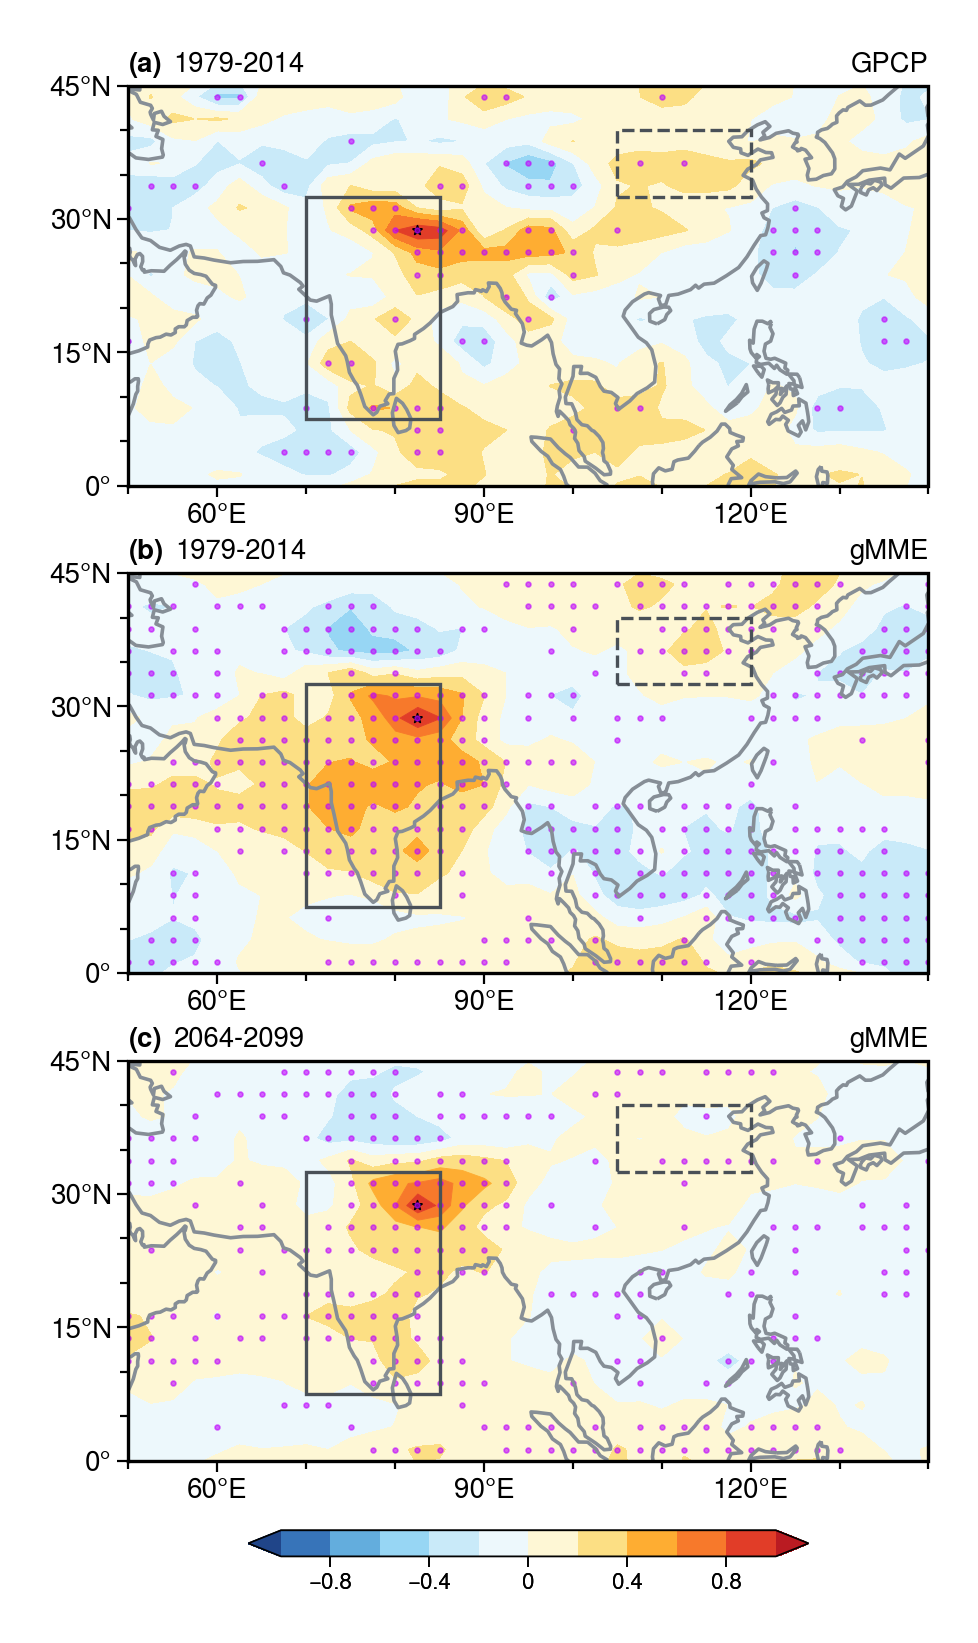

In [9]:
# plot the precipitation correlation map
India_N = 32.5
# India_N = 30.0
India_S = 7.5
India_W = 70.0
India_E = 85.0
NC_N = 40.0
NC_S = 32.5
NC_W = 105.0
NC_E = 120.0

pplt.rc.grid = False
pplt.rc.reso = "lo"
pplt.rc["figure.facecolor"] = "white"
pplt.rc["font.large"]
cl = 0  # 设置地图投影的中心纬度
proj = pplt.PlateCarree(central_longitude=cl)

fig = pplt.figure(span=False, share=False, refwidth=4.0, wspace=4.0, hspace=3.5, outerpad=2.0)
plot_array = np.reshape(range(1, 4), (3, 1))
axs = fig.subplots(plot_array, proj=proj)

#   set the geo_ticks and map projection to the plots
xticks = np.array([60, 90, 120])  # 设置纬度刻度
yticks = np.arange(0, 46, 15)  # 设置经度刻度
# 设置绘图的经纬度范围extents，其中前两个参数为经度的最小值和最大值，后两个数为纬度的最小值和最大值
# 当想要显示的经纬度范围不是正好等于刻度显示范围时，对extents进行相应的修改即可
extents = [50.0, 140.0, yticks[0], 45.0]
sepl.geo_ticks(axs, xticks, yticks, cl, extents, majorticklabelsize=10)

# ===================================================
ski = 2
n = 1
w, h = 0.12, 0.14
# ===================================================
for ax in axs:
    # India area
    x0 = India_W
    y0 = India_S
    width = India_E-India_W
    height = India_N-India_S
    sepl.patches(ax, x0 - cl, y0, width, height, proj, linestyle="-", linewidth=1.2)
    # NC area
    x0 = NC_W
    y0 = NC_S
    width = NC_E-NC_W
    height = NC_N-NC_S
    sepl.patches(ax, x0 - cl, y0, width, height, proj, linewidth=1.2)
    ax.scatter(82.5, 28.75, color="black", marker="*", ms=12)
# ===================================================
con = axs[0].contourf(
    pre_GPCP_sp_pre_rvalue,
    cmap="ColdHot",
    cmap_kw={"left": 0.06, "right": 0.94},
    levels=np.arange(-1.0,1.1,0.2),
    zorder=0.8,
    extend="both"
    )
sepl.plt_sig(
    pre_GPCP_sp_pre_rvalue, axs[0], n, np.where(pre_GPCP_sp_pre_pvalue[::n, ::n] < 0.10), "bright purple", 12.0,
)

axs[0].format(
    ltitle="1979-2014", rtitle="GPCP",
)
# ===================================================
con = axs[1].contourf(
    pre_his_sp_pre_rvalue_gens,
    cmap="ColdHot",
    cmap_kw={"left": 0.06, "right": 0.94},
    levels=np.arange(-1.0,1.1,0.2),
    zorder=0.8,
    extend="both",
    )
sepl.plt_sig(
    pre_his_sp_pre_rvalue_gens, axs[1], n, np.where(pre_his_sp_pre_rvalue_gens_mask[::n, ::n] > 0.00), "bright purple", 12.0,
)

axs[1].format(
    ltitle="1979-2014", rtitle="gMME",
)
# ===================================================
con = axs[2].contourf(
    pre_ssp585_p3_sp_pre_rvalue_gens,
    cmap="ColdHot",
    cmap_kw={"left": 0.06, "right": 0.94},
    levels=np.arange(-1.0,1.1,0.2),
    zorder=0.8,
    extend="both",
    )
sepl.plt_sig(
    pre_ssp585_p3_sp_pre_rvalue_gens, axs[2], n, np.where(pre_ssp585_p3_sp_pre_rvalue_gens_mask[::n, ::n] > 0.00), "bright purple", 12.0,
)

axs[2].format(
    ltitle="2064-2099", rtitle="gMME",
)
# ===================================================
cb = fig.colorbar(con, loc="b", width=0.13, length=0.7, label="", ticklabelsize=8)
cb.set_ticks(np.arange(-2.0,2.1, 0.4))
axs.format(linewidth=1.2)
fig.format(abc="(a)", abcloc="l")

In [10]:
preGPCP_JJA.coords["time"] = hgtERA5_ver_JJA.coords["time"]
# recalculate the regression data
(
    sp_ERA5_hgt_slope,
    sp_ERA5_hgt_intercept,
    sp_ERA5_hgt_rvalue,
    sp_ERA5_hgt_pvalue,
    sp_ERA5_hgt_hypothesis,
) = ca.dim_linregress(preGPCP_JJA.sel(lat=28.75, lon=82.5), hgtERA5_ver_JJA.sel(level=[200.0, 500.0, 850.0]))

(
    sp_ERA5_u_slope,
    sp_ERA5_u_intercept,
    sp_ERA5_u_rvalue,
    sp_ERA5_u_pvalue,
    sp_ERA5_u_hypothesis,
) = ca.dim_linregress(preGPCP_JJA.sel(lat=28.75, lon=82.5), uERA5_ver_JJA.sel(level=[200.0, 500.0, 850.0]))

(
    sp_ERA5_v_slope,
    sp_ERA5_v_intercept,
    sp_ERA5_v_rvalue,
    sp_ERA5_v_pvalue,
    sp_ERA5_v_hypothesis,
) = ca.dim_linregress(preGPCP_JJA.sel(lat=28.75, lon=82.5), vERA5_ver_JJA.sel(level=[200.0, 500.0, 850.0]))

(
    sp_his_hgt_slope,
    sp_his_hgt_intercept,
    sp_his_hgt_rvalue,
    sp_his_hgt_pvalue,
    sp_his_hgt_hypothesis,
) = ca.dim_linregress(prehis_JJA.sel(lat=28.75, lon=82.5), hgthis_ver_JJA.sel(level=[200.0, 500.0, 850.0]))

(
    sp_his_u_slope,
    sp_his_u_intercept,
    sp_his_u_rvalue,
    sp_his_u_pvalue,
    sp_his_u_hypothesis,
) = ca.dim_linregress(prehis_JJA.sel(lat=28.75, lon=82.5), uhis_ver_JJA.sel(level=[200.0, 500.0, 850.0]))

(
    sp_his_v_slope,
    sp_his_v_intercept,
    sp_his_v_rvalue,
    sp_his_v_pvalue,
    sp_his_v_hypothesis,
) = ca.dim_linregress(prehis_JJA.sel(lat=28.75, lon=82.5), vhis_ver_JJA.sel(level=[200.0, 500.0, 850.0]))

(
    sp_ssp585_p3_hgt_slope,
    sp_ssp585_p3_hgt_intercept,
    sp_ssp585_p3_hgt_rvalue,
    sp_ssp585_p3_hgt_pvalue,
    sp_ssp585_p3_hgt_hypothesis,
) = ca.dim_linregress(pressp585_p3_JJA.sel(lat=28.75, lon=82.5), hgtssp585_p3_ver_JJA.sel(level=[200.0, 500.0, 850.0]))

(
    sp_ssp585_p3_u_slope,
    sp_ssp585_p3_u_intercept,
    sp_ssp585_p3_u_rvalue,
    sp_ssp585_p3_u_pvalue,
    sp_ssp585_p3_u_hypothesis,
) = ca.dim_linregress(pressp585_p3_JJA.sel(lat=28.75, lon=82.5), ussp585_p3_ver_JJA.sel(level=[200.0, 500.0, 850.0]))

(
    sp_ssp585_p3_v_slope,
    sp_ssp585_p3_v_intercept,
    sp_ssp585_p3_v_rvalue,
    sp_ssp585_p3_v_pvalue,
    sp_ssp585_p3_v_hypothesis,
) = ca.dim_linregress(pressp585_p3_JJA.sel(lat=28.75, lon=82.5), vssp585_p3_ver_JJA.sel(level=[200.0, 500.0, 850.0]))

In [14]:
#   calculate the windcheck and ensmean
# sp_ERA5_wind_mask = ca.wind_check(
#     xr.where(sp_ERA5_u_pvalue <= 0.05, 1.0, 0.0),
#     xr.where(sp_ERA5_v_pvalue <= 0.05, 1.0, 0.0),
#     xr.where(sp_ERA5_u_pvalue <= 0.05, 1.0, 0.0),
#     xr.where(sp_ERA5_v_pvalue <= 0.05, 1.0, 0.0),
# )

# sp_his_wind_mask = ca.wind_check(
#     xr.where(sp_his_u_pvalue <= 0.05, 1.0, 0.0),
#     xr.where(sp_his_v_pvalue <= 0.05, 1.0, 0.0),
#     xr.where(sp_his_u_pvalue <= 0.05, 1.0, 0.0),
#     xr.where(sp_his_v_pvalue <= 0.05, 1.0, 0.0),
# )

# sp_ssp585_p3_wind_mask = ca.wind_check(
#     xr.where(sp_ssp585_p3_u_pvalue <= 0.05, 1.0, 0.0),
#     xr.where(sp_ssp585_p3_v_pvalue <= 0.05, 1.0, 0.0),
#     xr.where(sp_ssp585_p3_u_pvalue <= 0.05, 1.0, 0.0),
#     xr.where(sp_ssp585_p3_v_pvalue <= 0.05, 1.0, 0.0),
# )

sp_his_hgt_slope_gens = sp_his_hgt_slope.sel(models=gmodels).mean(dim="models", skipna=True)
sp_his_hgt_slope_gens_mask = ca.MME_mask(sp_his_hgt_slope.sel(models=gmodels), chenandyu=True, big=True)

sp_ssp585_p3_hgt_slope_gens = sp_ssp585_p3_hgt_slope.sel(models=gmodels).mean(dim="models", skipna=True)
sp_ssp585_p3_hgt_slope_gens_mask = ca.MME_mask(sp_ssp585_p3_hgt_slope.sel(models=gmodels), chenandyu=True, big=True)

sp_his_u_slope_gens = sp_his_u_slope.sel(models=gmodels).mean(dim="models", skipna=True)
sp_his_u_slope_gens_mask = ca.MME_mask(sp_his_u_slope.sel(models=gmodels), chenandyu=True, big=True)

sp_ssp585_p3_u_slope_gens = sp_ssp585_p3_u_slope.sel(models=gmodels).mean(dim="models", skipna=True)
sp_ssp585_p3_u_slope_gens_mask = ca.MME_mask(sp_ssp585_p3_u_slope.sel(models=gmodels), chenandyu=True, big=True)

sp_his_v_slope_gens = sp_his_v_slope.sel(models=gmodels).mean(dim="models", skipna=True)
sp_his_v_slope_gens_mask = ca.MME_mask(sp_his_v_slope.sel(models=gmodels), chenandyu=True, big=True)

sp_ssp585_p3_v_slope_gens = sp_ssp585_p3_v_slope.sel(models=gmodels).mean(dim="models", skipna=True)
sp_ssp585_p3_v_slope_gens_mask = ca.MME_mask(sp_ssp585_p3_v_slope.sel(models=gmodels), chenandyu=True, big=True)


sp_diff_hgt_slope = sp_ssp585_p3_hgt_slope - sp_his_hgt_slope
sp_diff_hgt_slope_gens = sp_diff_hgt_slope.sel(models=gmodels).mean(dim="models", skipna=True)

sp_diff_hgt_gens_mask = ca.MME_mask(sp_diff_hgt_slope.sel(models=gmodels), big=True)

sp_diff_u_slope = sp_ssp585_p3_u_slope - sp_his_u_slope
sp_diff_u_slope_gens = sp_diff_u_slope.sel(models=gmodels).mean(dim="models", skipna=True)

sp_diff_u_gens_mask = ca.MME_mask(sp_diff_u_slope.sel(models=gmodels), big=True)

sp_diff_v_slope = sp_ssp585_p3_v_slope - sp_his_v_slope
sp_diff_v_slope_gens = sp_diff_v_slope.sel(models=gmodels).mean(dim="models", skipna=True)

sp_diff_v_gens_mask = ca.MME_mask(sp_diff_v_slope.sel(models=gmodels), big=True)
# sp_his_hgt_rvalue_ens = ca.cal_rMME(sp_his_hgt_rvalue, "models")
# sp_his_hgt_rvalue_ens_mask = xr.where((ca.MME_reg_mask(sp_his_hgt_rvalue_ens, sp_his_hgt_rvalue.std(dim="models", skipna=True), len(models), True) + ca.cal_mmemask(sp_his_hgt_slope)) >= 2.0, 1.0, 0.0)

# sp_ssp585_p3_hgt_rvalue_ens = ca.cal_rMME(sp_ssp585_p3_hgt_rvalue, "models")
# sp_ssp585_p3_hgt_rvalue_ens_mask = xr.where((ca.MME_reg_mask(sp_ssp585_p3_hgt_rvalue_ens, sp_ssp585_p3_hgt_rvalue.std(dim="models", skipna=True), len(models), True) + ca.cal_mmemask(sp_ssp585_p3_hgt_slope)) >= 2.0, 1.0, 0.0)

# sp_his_u_rvalue_ens = ca.cal_rMME(sp_his_u_rvalue, "models")
# sp_his_u_rvalue_ens_mask = xr.where((ca.MME_reg_mask(sp_his_u_rvalue_ens, sp_his_u_rvalue.std(dim="models", skipna=True), len(models), True) + ca.cal_mmemask(sp_his_u_slope)) >= 2.0, 1.0, 0.0)

# sp_ssp585_p3_u_rvalue_ens = ca.cal_rMME(sp_ssp585_p3_u_rvalue, "models")
# sp_ssp585_p3_u_rvalue_ens_mask = xr.where((ca.MME_reg_mask(sp_ssp585_p3_u_rvalue_ens, sp_ssp585_p3_u_rvalue.std(dim="models", skipna=True), len(models), True) + ca.cal_mmemask(sp_ssp585_p3_u_slope)) >= 2.0, 1.0, 0.0)

# sp_his_v_rvalue_ens = ca.cal_rMME(sp_his_v_rvalue, "models")
# sp_his_v_rvalue_ens_mask = xr.where((ca.MME_reg_mask(sp_his_v_rvalue_ens, sp_his_v_rvalue.std(dim="models", skipna=True), len(models), True) + ca.cal_mmemask(sp_his_v_slope)) >= 2.0, 1.0, 0.0)

# sp_ssp585_p3_v_rvalue_ens = ca.cal_rMME(sp_ssp585_p3_v_rvalue, "models")
# sp_ssp585_p3_v_rvalue_ens_mask = xr.where((ca.MME_reg_mask(sp_ssp585_p3_v_rvalue_ens, sp_ssp585_p3_v_rvalue.std(dim="models", skipna=True), len(models), True) + ca.cal_mmemask(sp_ssp585_p3_v_slope)) >= 2.0, 1.0, 0.0)

sp_his_wind_gens_mask = ca.wind_check(
    xr.where(sp_his_u_slope_gens_mask > 0.0, 1.0, 0.0),
    xr.where(sp_his_v_slope_gens_mask > 0.0, 1.0, 0.0),
    xr.where(sp_his_u_slope_gens_mask > 0.0, 1.0, 0.0),
    xr.where(sp_his_v_slope_gens_mask > 0.0, 1.0, 0.0),
)
sp_ssp585_p3_wind_gens_mask = ca.wind_check(
    xr.where(sp_ssp585_p3_u_slope_gens_mask > 0.0, 1.0, 0.0),
    xr.where(sp_ssp585_p3_v_slope_gens_mask > 0.0, 1.0, 0.0),
    xr.where(sp_ssp585_p3_u_slope_gens_mask > 0.0, 1.0, 0.0),
    xr.where(sp_ssp585_p3_v_slope_gens_mask > 0.0, 1.0, 0.0),
)
sp_diff_wind_gens_mask = ca.wind_check(
    xr.where(sp_diff_u_gens_mask > 0.0, 1.0, 0.0),
    xr.where(sp_diff_v_gens_mask > 0.0, 1.0, 0.0),
    xr.where(sp_diff_u_gens_mask > 0.0, 1.0, 0.0),
    xr.where(sp_diff_v_gens_mask > 0.0, 1.0, 0.0),
)

/home/ys17-23/chenhj/self_def/plot.py:89: ProplotWarning: Calling arbitrary axes methods from SubplotGrid was deprecated in v0.8 and will be removed in a future release. Please index the grid or loop over the grid instead.
  axs.set_extent(extents, crs=proj)
/home/ys17-23/chenhj/self_def/plot.py:90: ProplotWarning: Calling arbitrary axes methods from SubplotGrid was deprecated in v0.8 and will be removed in a future release. Please index the grid or loop over the grid instead.
  axs.set_xticks(lonticks, crs=proj)
/home/ys17-23/chenhj/self_def/plot.py:91: ProplotWarning: Calling arbitrary axes methods from SubplotGrid was deprecated in v0.8 and will be removed in a future release. Please index the grid or loop over the grid instead.
  axs.set_yticks(latticks, crs=proj)
/home/ys17-23/chenhj/self_def/plot.py:94: ProplotWarning: Calling arbitrary axes methods from SubplotGrid was deprecated in v0.8 and will be removed in a future release. Please index the grid or loop over the grid instead

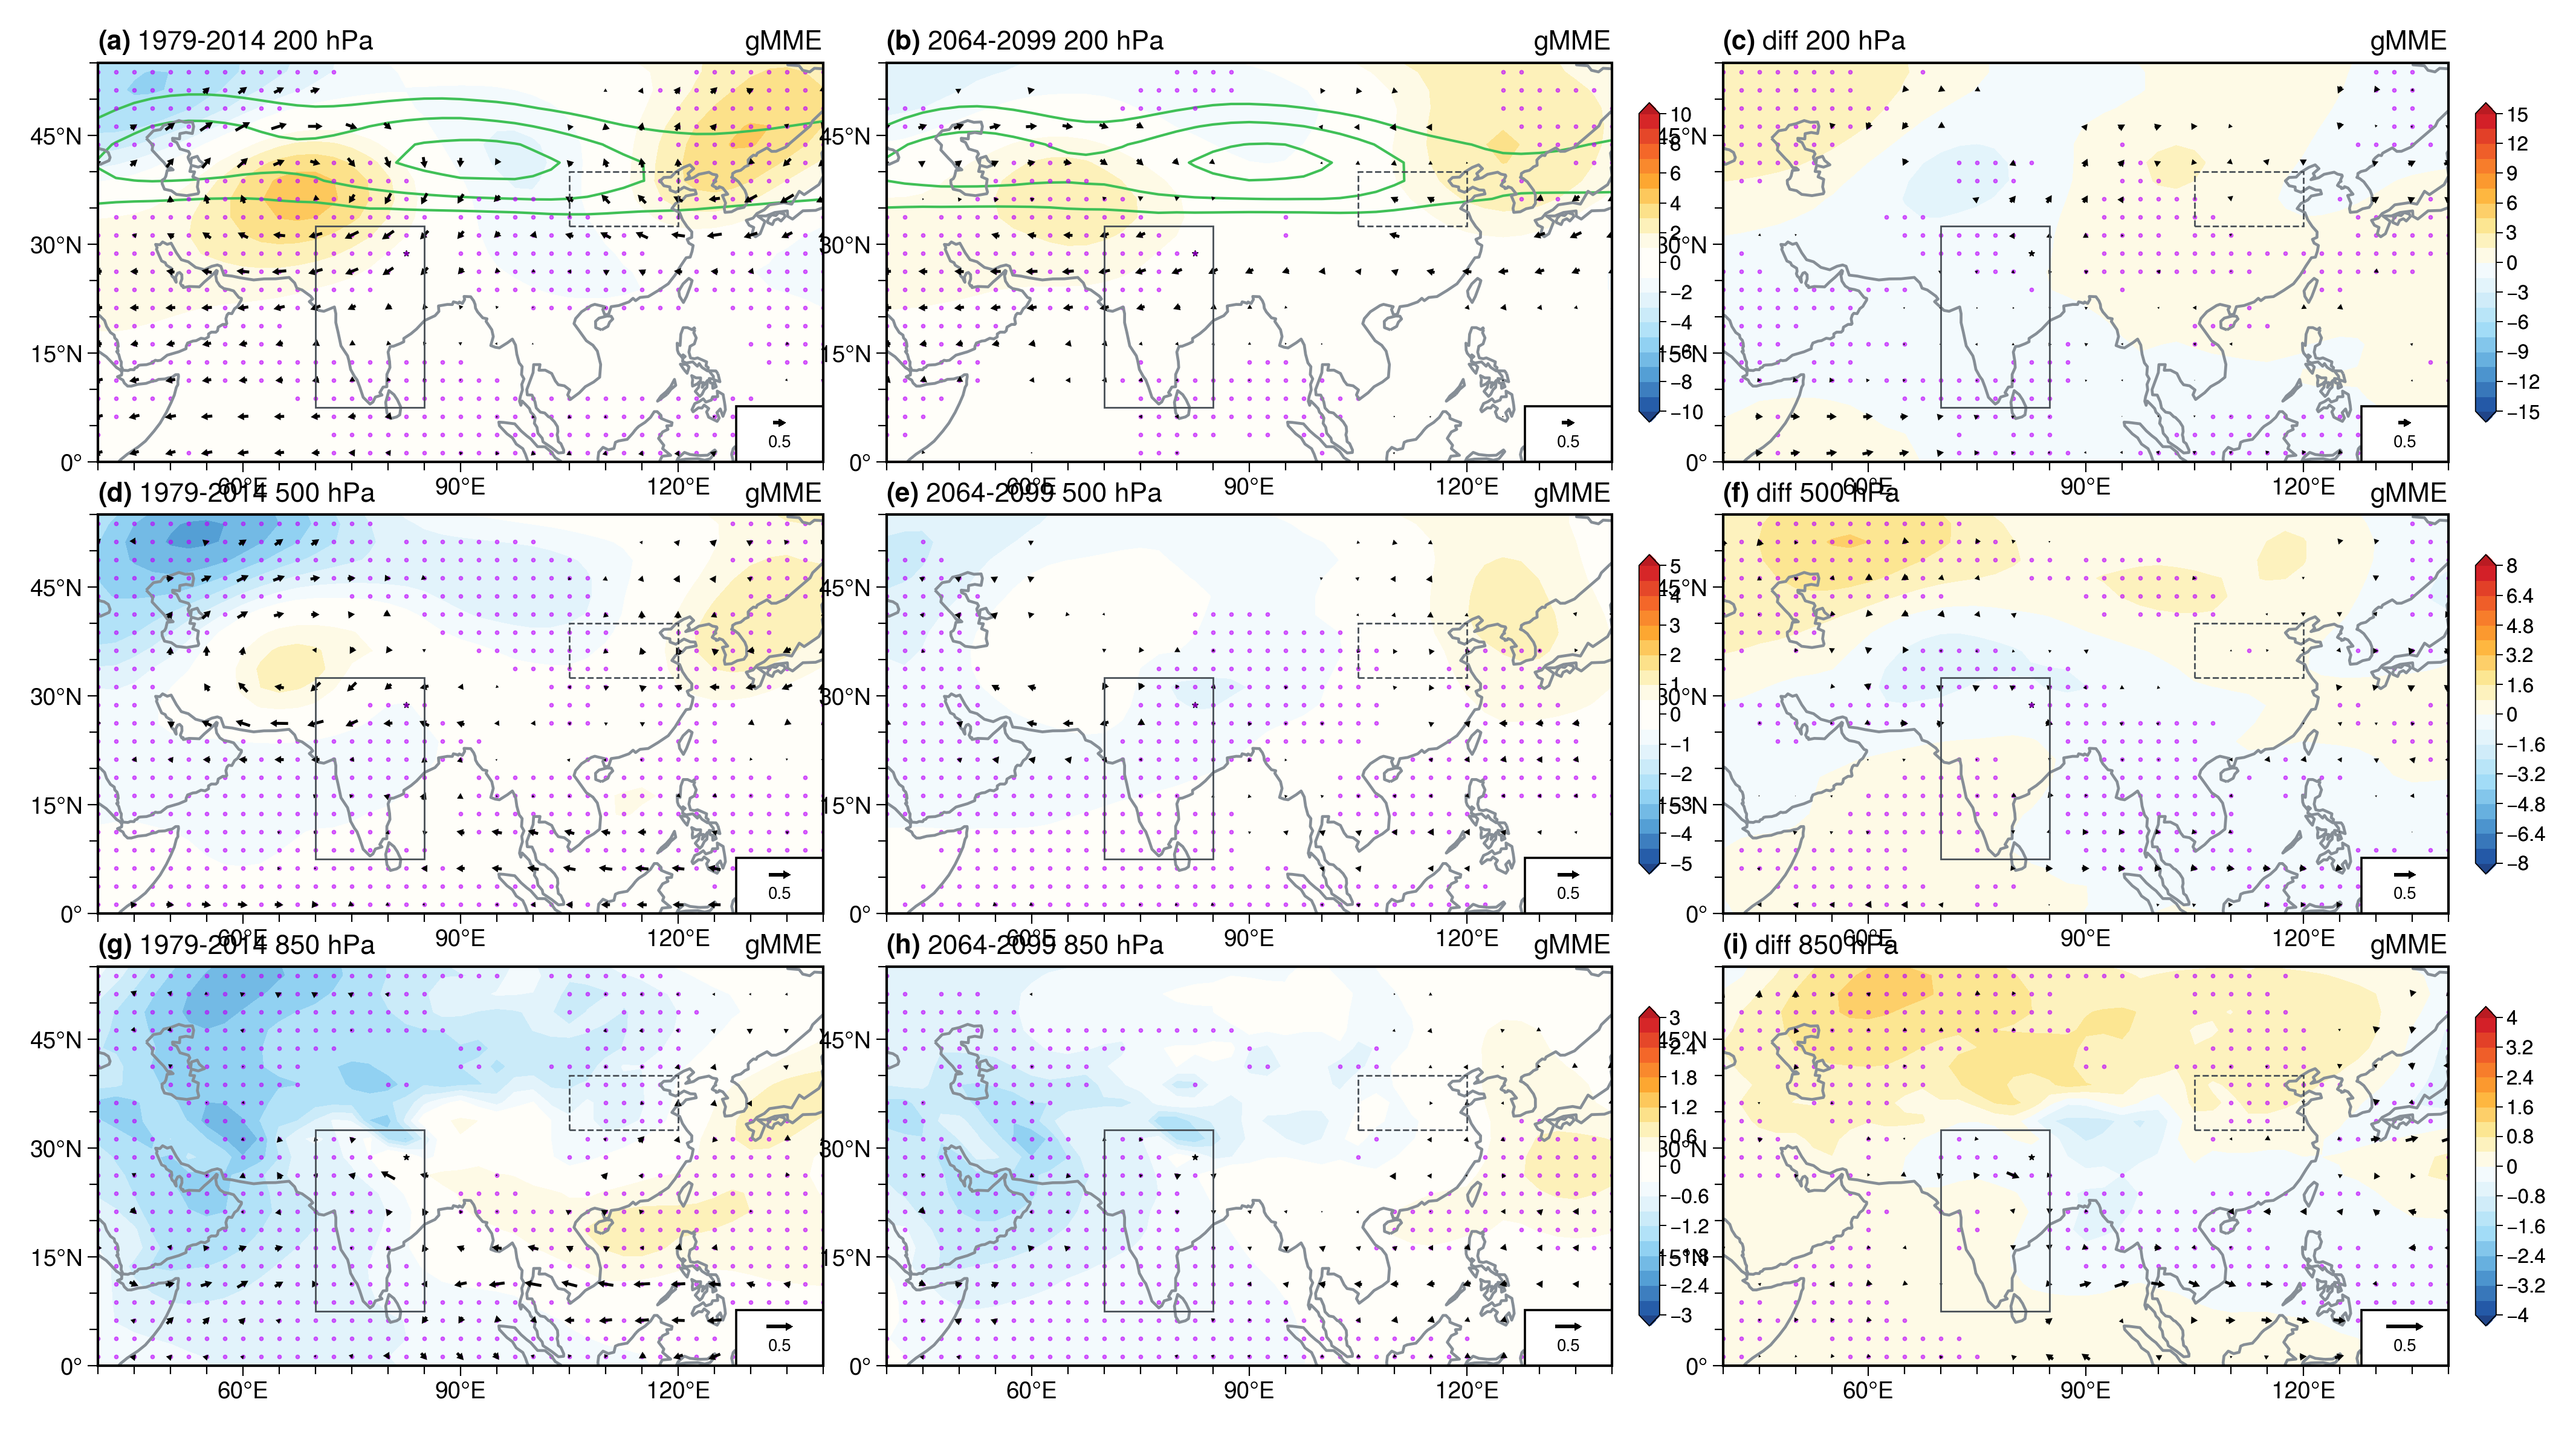

In [16]:
startlevel=[-10, -5, -3]
spacinglevel=[1.0, 0.5, 0.3]
scalelevel=[0.30, 0.17, 0.14]


diffstartlevel=[-15, -8, -4]
diffspacinglevel=[1.5, 0.8, 0.4]
diffscalelevel=[0.30, 0.17, 0.10]

pplt.rc.grid = False
pplt.rc.reso = "lo"
pplt.rc["figure.facecolor"] = "white"
pplt.rc["font.large"] = 16
cl = 0  # 设置地图投影的中心纬度
proj = pplt.PlateCarree(central_longitude=cl)

fig = pplt.figure(span=False, share=False, refwidth=6.0, wspace=[4.2], hspace=3.5, outerpad=2.0)
plot_array = np.reshape(range(1, 10), (3, 3))
# plot_array[-1,-1] = 0
axs = fig.subplots(plot_array, proj=proj)

#   set the geo_ticks and map projection to the plots
# xticks = np.array([30, 60, 90, 120, 150, 180])  # 设置纬度刻度
xticks = np.array([60, 90, 120])  # 设置纬度刻度
yticks = np.arange(0, 46, 15)  # 设置经度刻度
# 设置绘图的经纬度范围extents，其中前两个参数为经度的最小值和最大值，后两个数为纬度的最小值和最大值
# 当想要显示的经纬度范围不是正好等于刻度显示范围时，对extents进行相应的修改即可
extents = [40.0, 140.0, yticks[0], 55.0]
sepl.geo_ticks(axs, xticks, yticks, cl, extents, majorticklabelsize=14, lonminorspace=5, coastlinewidth=1.7, majorticklabelpad=3.0, majorticklen=6.0, minorticklen=5.0)
# ===================================================
ski = 2
n = 1
w, h = 0.12, 0.14
# ======================================
for ax in axs:
    rect = Rectangle((1 - w, 0), w, h, transform=ax.transAxes, fc="white", ec="k", lw=1.3, zorder=1.1)
    ax.add_patch(rect)
    # India area
    x0 = India_W
    y0 = India_S
    width = India_E-India_W
    height = India_N-India_S
    sepl.patches(ax, x0 - cl, y0, width, height, proj, linestyle="-")
    # NC area
    x0 = NC_W
    y0 = NC_S
    width = NC_E-NC_W
    height = NC_N-NC_S
    sepl.patches(ax, x0 - cl, y0, width, height, proj)
    ax.scatter(82.5, 28.75, color="black", marker="*", ms=12)
    # # SJ-KP area
    # x0 = SJ_W
    # y0 = SJ_S
    # width = SJ_E-SJ_W
    # height = SJ_N-SJ_S
    # sepl.patches(ax, x0 - cl, y0, width, height, proj)
# ======================================
for num_lev,lev in enumerate([200.0, 500.0, 850.0]):
    # if lev == 200.0:
    #     #   WAhigh
    #     x0 = WAhigh_W
    #     y0 = WAhigh_S
    #     width = WAhigh_E-WAhigh_W
    #     height = WAhigh_N-WAhigh_S
    #     sepl.patches(axs[num_lev, 0], x0 - cl, y0, width, height, proj, edgecolor="bright purple", linestyle="-", linewidth=1.7)
    #     #   EAhigh
    #     x0 = EAhigh_W
    #     y0 = EAhigh_S
    #     width = EAhigh_E-EAhigh_W
    #     height = EAhigh_N-EAhigh_S
    #     sepl.patches(axs[num_lev, 0], x0 - cl, y0, width, height, proj, edgecolor="bright purple", linestyle="-", linewidth=1.7)
    # elif lev == 850.0:
    #     #   WNPhigh
    #     x0 = WNPhigh_W
    #     y0 = WNPhigh_S
    #     width = WNPhigh_E-WNPhigh_W
    #     height = WNPhigh_N-WNPhigh_S
    #     sepl.patches(axs[num_lev, 0], x0 - cl, y0, width, height, proj, edgecolor="bright purple", linestyle="-", linewidth=1.7)
    # ======================================
    con = axs[num_lev, 0].contourf(
        sp_his_hgt_slope_gens.sel(level=lev),
        cmap="ColdHot",
        cmap_kw={"left": 0.06, "right": 0.94, "cut": -0.1},
        levels=np.arange(startlevel[num_lev], -startlevel[num_lev]+spacinglevel[num_lev], spacinglevel[num_lev]),
        zorder=0.8,
        extend="both"
    )
    if lev == 200.0:
        axs[num_lev, 0].contour(
          uhis_ver_JJA.sel(level=200.0, models=gmodels).mean(dim=["time","models"]).loc[0.0:,:],
          color="green6",
          levels=np.array([20.0, 25.0, 30.0]),
          zorder=0.8
        )
    # if lev == 200.0:
    #   axs[num_lev, 0].contour(
    #   sp_his_div_slope_gens.sel(level=lev),
    #   color="green",
    #   levels=np.arange(-5e-6, 6e-6, 2.0e-7),
    #   zorder=0.8,
    #   nozero=True
    #   )
    # elif lev == 500.0:
    #   axs[num_lev, 0].contour(
    #   sp_his_w_slope_gens,
    #   color="green",
    #   levels=np.arange(-5e-3, 6e-3, 2.5e-3),
    #   nozero=True,
    #   zorder=0.8
    #   )  
    # elif lev == 850.0:
    #   axs[num_lev, 0].contour(
    #   sp_his_div_slope_gens.sel(level=lev),
    #   color="green",
    #   levels=np.arange(-3e-7, 3.5e-7, 1e-7),
    #   zorder=0.8,
    #   nozero=True
    #   )
    sepl.plt_sig(
        sp_his_hgt_slope_gens.sel(level=lev), axs[num_lev, 0], n, np.where(sp_his_hgt_slope_gens_mask.sel(level=lev)[::n, ::n] > 0.00), "bright purple", 19.0,
    )
    # axs[num_lev, 0].quiver(
    #     sp_his_u_slope_gens.sel(level=lev)[::ski, ::ski],
    #     sp_his_v_slope_gens.sel(level=lev)[::ski, ::ski],
    #     zorder=1.1,
    #     headwidth=2.6,
    #     headlength=2.3,
    #     headaxislength=2.3,
    #     scale_units="xy",
    #     scale=scalelevel[num_lev],
    #     pivot="mid",
    #     color="grey6",
    # )

    m = axs[num_lev, 0].quiver(
        sp_his_u_slope_gens.sel(level=lev).where(sp_his_wind_gens_mask.sel(level=lev) > 0.0)[::ski, ::ski],
        sp_his_v_slope_gens.sel(level=lev).where(sp_his_wind_gens_mask.sel(level=lev) > 0.0)[::ski, ::ski],
        zorder=1.1,
        headwidth=2.6,
        headlength=2.3,
        headaxislength=2.3,
        minlength=0.5,
        width=0.004,
        scale_units="xy",
        scale=scalelevel[num_lev],
        pivot="mid",
        color="black",
    )

    qk = axs[num_lev, 0].quiverkey(
        m, X=1 - w / 2, Y=0.7 * h, U=0.5, label="0.5", labelpos="S", labelsep=0.10, fontproperties={"size":10}, zorder=3.1,
    )
    axs[num_lev, 0].format(
        ltitle="1979-2014 {:.0f} hPa".format(lev), rtitle="gMME",
    )
	# ======================================
    con = axs[num_lev, 1].contourf(
        sp_ssp585_p3_hgt_slope_gens.sel(level=lev),
        cmap="ColdHot",
        cmap_kw={"left": 0.06, "right": 0.94, "cut": -0.1},
        levels=np.arange(startlevel[num_lev], -startlevel[num_lev]+spacinglevel[num_lev], spacinglevel[num_lev]),
        zorder=0.8,
        extend="both"
    )
    sepl.plt_sig(
        sp_ssp585_p3_hgt_slope_gens.sel(level=lev), axs[num_lev, 1], n, np.where(sp_ssp585_p3_hgt_slope_gens_mask.sel(level=lev)[::n, ::n] > 0.00), "bright purple", 19.0,
    )
    if lev == 200.0:
        axs[num_lev, 1].contour(
          ussp585_p3_ver_JJA.sel(level=200.0, models=gmodels).mean(dim=["time","models"]).loc[0.0:,:],
          color="green6",
          levels=np.array([20.0, 25.0, 30.0]),
          zorder=0.8
        )
    # if lev == 200.0:
    #   axs[num_lev, 1].contour(
    #   sp_ssp585_p3_div_slope_gens.sel(level=lev),
    #   color="green",
    #   levels=np.arange(-5e-6, 6e-6, 2.0e-7),
    #   zorder=0.8,
    #   nozero=True
    #   )
    # elif lev == 500.0:
    #   axs[num_lev, 1].contour(
    #   sp_ssp585_p3_w_slope_gens,
    #   color="green",
    #   levels=np.arange(-5e-3, 6e-3, 2.5e-3),
    #   nozero=True,
    #   zorder=0.8
    #   )  
    # elif lev == 850.0:
    #   axs[num_lev, 1].contour(
    #   sp_ssp585_p3_div_slope_gens.sel(level=lev),
    #   color="green",
    #   levels=np.arange(-3e-7, 3.5e-7, 1e-7),
    #   zorder=0.8,
    #   nozero=True
    #   )
    # axs[num_lev, 1].quiver(
    #     sp_ssp585_p3_u_slope_gens.sel(level=lev)[::ski, ::ski],
    #     sp_ssp585_p3_v_slope_gens.sel(level=lev)[::ski, ::ski],
    #     zorder=1.1,
    #     headwidth=2.6,
    #     headlength=2.3,
    #     headaxislength=2.3,
    #     scale_units="xy",
    #     scale=scalelevel[num_lev],
    #     pivot="mid",
    #     color="grey6",
    # )

    m = axs[num_lev, 1].quiver(
        sp_ssp585_p3_u_slope_gens.sel(level=lev).where(sp_ssp585_p3_wind_gens_mask.sel(level=lev) > 0.0)[::ski, ::ski],
        sp_ssp585_p3_v_slope_gens.sel(level=lev).where(sp_ssp585_p3_wind_gens_mask.sel(level=lev) > 0.0)[::ski, ::ski],
        zorder=1.1,
        headwidth=2.6,
        headlength=2.3,
        headaxislength=2.3,
        minlength=0.5,
        width=0.004,
        scale_units="xy",
        scale=scalelevel[num_lev],
        pivot="mid",
        color="black",
    )

    qk = axs[num_lev, 1].quiverkey(
        m, X=1 - w / 2, Y=0.7 * h, U=0.5, label="0.5", labelpos="S", labelsep=0.10, fontproperties={"size":10}, zorder=3.1,
    )
    axs[num_lev, 1].format(
        ltitle="2064-2099 {:.0f} hPa".format(lev), rtitle="gMME",
    )
    cb = axs[num_lev, 1].colorbar(con, loc="r", width=0.17, length=0.8, label="", ticklabelsize=12, pad=1.8)
    cb.set_ticks(np.arange(startlevel[num_lev], -startlevel[num_lev]+spacinglevel[num_lev], spacinglevel[num_lev]*2))
    # ======================================
    con = axs[num_lev, 2].contourf(
        sp_diff_hgt_slope_gens.sel(level=lev),
        cmap="ColdHot",
        cmap_kw={"left": 0.06, "right": 0.94},
        levels=np.arange(diffstartlevel[num_lev], -diffstartlevel[num_lev]+diffspacinglevel[num_lev], diffspacinglevel[num_lev]),
        zorder=0.8,
        extend="both"
    )
    sepl.plt_sig(
        sp_diff_hgt_slope_gens.sel(level=lev), axs[num_lev, 2], n, np.where(sp_diff_hgt_gens_mask.sel(level=lev)[::n, ::n] > 0.00), "bright purple", 19.0,
    )
    # axs[num_lev, 2].quiver(
    #     sp_diff_u_slope_gens.sel(level=lev)[::ski, ::ski],
    #     sp_diff_v_slope_gens.sel(level=lev)[::ski, ::ski],
    #     zorder=1.1,
    #     headwidth=2.6,
    #     headlength=2.3,
    #     headaxislength=2.3,
    #     scale_units="xy",
    #     scale=scalelevel[num_lev],
    #     pivot="mid",
    #     color="grey6",
    # )

    m = axs[num_lev, 2].quiver(
        sp_diff_u_slope_gens.sel(level=lev).where(sp_diff_wind_gens_mask.sel(level=lev) > 0.0)[::ski, ::ski],
        sp_diff_v_slope_gens.sel(level=lev).where(sp_diff_wind_gens_mask.sel(level=lev) > 0.0)[::ski, ::ski],
        zorder=1.1,
        headwidth=2.6,
        headlength=2.3,
        headaxislength=2.3,
        minlength=0.1,
        width=0.004,
        scale_units="xy",
        scale=diffscalelevel[num_lev],
        pivot="mid",
        color="black",
    )

    qk = axs[num_lev, 2].quiverkey(
        m, X=1 - w / 2, Y=0.7 * h, U=0.5, label="0.5", labelpos="S", labelsep=0.10, fontproperties={"size":10}, zorder=3.1,
    )
    axs[num_lev, 2].format(
        ltitle="diff {:.0f} hPa".format(lev), rtitle="gMME",
    )
    cb = axs[num_lev, 2].colorbar(con, loc="r", width=0.17, length=0.8, label="", ticklabelsize=12, pad=1.8)
    cb.set_ticks(np.arange(diffstartlevel[num_lev], -diffstartlevel[num_lev]+diffspacinglevel[num_lev], diffspacinglevel[num_lev]*2))
# ======================================
axs.format(linewidth=1.5, titlepad=8.0, rc_kw={"contour.negative_linestyle":"-"})
fig.format(abc="(a)", abcloc="l")